# Women in Big Data South Africa - StatsSA

This notebook introduces the Zindi competition **Women in Big Data South Africa - Women-Headed Households in South Africa**. We'll take a quick look at the data, show how to create a model, estimate the score you'll get on Zindi, prepare your submission and get onto the leaderboard. I've also given some hints as to how to get a better score - once you have your first submission in, these might give you some ideas for what to try next.

# Loading the data
Make sure the CSV files provided by Zindi are in the same folder as this notebook. If it's running on Google Colab, you can use the 'files' tab on the left to upload them. We load the training data from Train.csv, and print out the variable descriptions here for easy reference. 

In [2034]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# import necessary modules
from geopandas import GeoDataFrame
# from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from geopy.distance import great_circle
import shapefile as shp
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)

from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points




from scipy import stats
from scipy.stats import norm, skew #for some statistics

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
# !pip install xlsx2csv
from xlsx2csv import Xlsx2csv
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
# https://github.com/rushter/MLAlgorithms

In [2035]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
Xlsx2csv("zaf_adm_2016_statssa_ocha_gazetteer.xlsx", outputencoding="utf-8").convert("pcode_4.csv")
pcode = pd.read_csv('pcode_4.csv')

In [2036]:
shp_path = "./zaf_adm_2016sadb_ocha_shp/zaf_admbnda_adm4_2016SADB_OCHA.shp" 
sf = shp.Reader(shp_path)

In [2037]:
len(sf.shapes())

4392

In [2038]:
sf.records()[1]

Record #1: ['ZA', 'South Africa', 'ZA9', 'LIM', 'Limpopo', 'Province', 'ZA934', 'DC34', 'Vhembe', 'District Municipality', 'ZA9344', 'LIM344', 'Makhado', 'Makhado', 'Local Municipality', 'ZA9344002', '002', 'Ward No.', 'Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA']

In [2039]:
sf.records()[0][2]

'ZA9'

## 1. Exploring Raw Data

### Converting shapefile data on Pandas dataframe

So, let's convert sf data on a dataframe and see how it looks like:

In [2040]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

adm4_pcode = read_shapefile(sf)
adm4_pcode.shape
adm4_pcode.head(2)

,ADM0_PCODE,ADM0_EN,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM1_TYPE,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_REF,ADM3_TYPE,ADM4_PCODE,ADM4_EN,ADM4_TYPE,SOURCE,coords
0,ZA,South Africa,ZA9,LIM,Limpopo,Province,ZA934,DC34,Vhembe,District Municipality,ZA9344,LIM344,Makhado,Makhado,Local Municipality,ZA9344001,001,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(30.088217081852918, -23.17143398339158), (30.088637981657598, -23.17162406679722), (30.089072460325838, -23.17162406679722), (30.089520515159677, -23.17162406679722), (30.08990068287028, -23.171..."
1,ZA,South Africa,ZA9,LIM,Limpopo,Province,ZA934,DC34,Vhembe,District Municipality,ZA9344,LIM344,Makhado,Makhado,Local Municipality,ZA9344002,002,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(30.064168009745913, -23.14930733716386), (30.06423130942744, -23.149639660941546), (30.06480579275319, -23.149579188728524), (30.06505775940815, -23.149569110026334), (30.065450826994095, -23.14..."


In [2041]:
adm4_pcode[adm4_pcode.ADM4_PCODE == 'ZA9344001']

,ADM0_PCODE,ADM0_EN,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM1_TYPE,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_REF,ADM3_TYPE,ADM4_PCODE,ADM4_EN,ADM4_TYPE,SOURCE,coords
0,ZA,South Africa,ZA9,LIM,Limpopo,Province,ZA934,DC34,Vhembe,District Municipality,ZA9344,LIM344,Makhado,Makhado,Local Municipality,ZA9344001,001,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(30.088217081852918, -23.17143398339158), (30.088637981657598, -23.17162406679722), (30.089072460325838, -23.17162406679722), (30.089520515159677, -23.17162406679722), (30.08990068287028, -23.171..."


In [2042]:
train[train.ADM4_PCODE == 'ZA9344001']

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
1665,93404001: Ward 1,3126.508,11993.863,41.171,0.863,0.133,0.001,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0,0,0.437,0.417,0.000,0.009,0.136,0.113,0.887,0.096,0.904,0.008,0.992,0.003,0.002,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.002,0.912,0.073,0.004,0,0.000,1.000,0.000,0.000,0.000,0.000,0.929,0.023,0.354,0.355,0.129,0.067,0.028,0.045,0,0,ZA9344001,-23.189,30.102,9.518


In [2043]:
test[test.ADM4_PCODE == 'ZA9344001']

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL


In [2044]:
train.shape

(2822, 63)

In [2045]:
test.shape

(1013, 62)

In [2046]:
pcode.shape

(213, 16)

In [2047]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0,0,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,0,0,ZA4161001,-29.682,24.735,0.292
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0,0,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,0,0,ZA4161002,-29.119,24.758,3.208
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0,0,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,0,0,ZA4161003,-29.142,25.094,0.000
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0,0,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,0,0,ZA4161004,-29.372,24.943,2.039
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0,0,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,0,0,ZA4161005,-29.409,25.290,0.000


In [2048]:
test.head()

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,21001001: Ward 1,2504.952,8745.152,0.947,0.001,0.002,0.000,0.000,0.030,0.000,0.013,0.004,0.000,0.001,0.002,0.000,0.000,0.247,0.615,0.000,0.017,0.121,0.155,0.845,0.217,0.783,0.174,0.826,0.818,0.023,0.001,0.126,0.000,0.000,0.003,0.006,0.000,0.000,0.000,0.000,0.005,0.000,0.019,0.173,0.736,0.004,0.083,0.004,0.921,0.552,0.427,0.012,0.002,0.000,0.000,0.007,0.000,0.000,ZA2101001,-32.638,23.849,0.000
1,21001002: Ward 2,2080.277,7258.118,0.845,0.000,0.044,0.005,0.012,0.012,0.022,0.022,0.017,0.007,0.006,0.007,0.000,0.000,0.193,0.532,0.001,0.053,0.221,0.406,0.594,0.499,0.501,0.367,0.633,0.435,0.106,0.000,0.289,0.001,0.001,0.002,0.003,0.001,0.000,0.000,0.000,0.006,0.000,0.154,0.471,0.192,0.003,0.325,0.009,0.955,0.760,0.227,0.010,0.001,0.000,0.000,0.003,0.000,0.000,ZA2101002,-31.991,24.556,0.000
2,21001003: Ward 3,1106.626,5919.132,0.651,0.008,0.007,0.000,0.002,0.260,0.007,0.044,0.014,0.000,0.000,0.008,0.000,0.000,0.296,0.499,0.011,0.079,0.115,0.237,0.763,0.190,0.810,0.090,0.910,0.953,0.015,0.000,0.018,0.001,0.000,0.002,0.001,0.003,0.002,0.001,0.000,0.003,0.000,0.000,0.080,0.915,0.002,0.001,0.003,0.976,0.704,0.292,0.002,0.002,0.000,0.000,0.000,0.000,0.000,ZA2101003,-32.284,24.564,8.270
3,21001004: Ward 4,2175.561,10280.575,0.411,0.002,0.012,0.000,0.000,0.450,0.009,0.102,0.002,0.009,0.000,0.003,0.000,0.000,0.265,0.519,0.000,0.014,0.201,0.343,0.657,0.348,0.652,0.249,0.751,0.852,0.021,0.001,0.018,0.000,0.001,0.001,0.005,0.001,0.000,0.000,0.000,0.001,0.000,0.099,0.102,0.833,0.007,0.055,0.003,0.966,0.556,0.440,0.002,0.000,0.001,0.000,0.001,0.000,0.000,ZA2101004,-32.262,24.542,8.627
4,21001005: Ward 5,1270.839,6018.342,0.943,0.003,0.001,0.000,0.001,0.001,0.001,0.028,0.002,0.017,0.000,0.004,0.000,0.000,0.285,0.552,0.000,0.053,0.109,0.256,0.744,0.182,0.818,0.138,0.862,0.966,0.012,0.000,0.011,0.001,0.000,0.002,0.005,0.001,0.000,0.001,0.000,0.002,0.000,0.000,0.034,0.957,0.007,0.000,0.003,0.952,0.444,0.553,0.001,0.000,0.000,0.000,0.002,0.000,0.000,ZA2101005,-32.252,24.559,8.602


In [21]:
lst = ["A"]
if len(lst) >0 :
    print("No way")
else:
    print("continue")
lst.size()

No way


AttributeError: 'list' object has no attribute 'size'

In [2050]:
train = pd.merge(train,adm4_pcode, how='inner', on=['ADM4_PCODE'])
test = pd.merge(test,adm4_pcode, how='inner', on=['ADM4_PCODE'])
train.shape,test.shape

((2822, 82), (1013, 81))

In [2051]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL,ADM0_PCODE,ADM0_EN,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM1_TYPE,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_REF,ADM3_TYPE,ADM4_EN,ADM4_TYPE,SOURCE,coords
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0,0,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,0,0,ZA4161001,-29.682,24.735,0.292,ZA,South Africa,ZA4,FS,Free State,Province,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Letsemeng,Local Municipality,001,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(24.696397002219953, -29.36626100224339), (24.69703699755945, -29.366284996155628), (24.720209999591873, -29.365164001117705), (24.72360199773408, -29.364999999850056), (24.725408999225976, -29.3..."
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0,0,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,0,0,ZA4161002,-29.119,24.758,3.208,ZA,South Africa,ZA4,FS,Free State,Province,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Letsemeng,Local Municipality,002,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(24.76746281255879, -29.099032610266704), (24.77239899971414, -29.119713000054844), (24.772185136434928, -29.119635450615533), (24.772504554941293, -29.12095305094249), (24.77000244585622, -29.12..."
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0,0,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,0,0,ZA4161003,-29.142,25.094,0.000,ZA,South Africa,ZA4,FS,Free State,Province,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Letsemeng,Local Municipality,003,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(24.797700001853627, -28.853749997364446), (24.81104000099532, -28.913079996744386), (24.83098999918917, -28.906760002072417), (24.84405000160632, -28.902619998214277), (24.85421999755488, -28.89..."
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0,0,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,0,0,ZA4161004,-29.372,24.943,2.039,ZA,South Africa,ZA4,FS,Free State,Province,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Letsemeng,Local Municipality,004,Ward No.,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,"[(24.98615100036841, -29.29077799990472), (25.000525999575245, -29.30170600023166), (25.007706999778293, -29.30716800030291), (25.015851000323437, -29.313360999910174), (25.01934699966438, -29.316..."
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0,0,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.

In [2052]:
# train['ADM4_EN'] = train['ADM4_EN'].map(lambda x: str(x)[:2])

# train = train.drop(['ADM0_PCODE','ADM0_EN', 'ADM1_EN','ADM1_TYPE','ADM2_EN','ADM3_EN','ADM3_REF','ADM4_TYPE','SOURCE','coords','ADM4_EN'], axis=1)


In [2053]:
# ['ADM1_EN','ADM2_EN','ADM3_EN','ADM4_EN']

# if len(train['ADM3_REF'].unique()) == len(train['ADM3_EN'].unique()):
#     print("yes")
# else:
#     print('No')
train['ADM4_EN'].unique()

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096', '097', '098', '099',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '124', '125', '126',
       '127', '128',

In [2054]:
train['ADM0_EN'].value_counts

<bound method IndexOpsMixin.value_counts of 0       South Africa
1       South Africa
2       South Africa
3       South Africa
4       South Africa
            ...     
2817    South Africa
2818    South Africa
2819    South Africa
2820    South Africa
2821    South Africa
Name: ADM0_EN, Length: 2822, dtype: object>

In [2055]:

# test['ADM3_PCODE'] = test['ADM4_PCODE'].map(lambda x: str(x)[:-3])

In [2056]:
# #replace: np.inf, -np.inf
print("Check if isfinite")
train = train.replace([np.inf, -np.inf], [train.mode(),train.mode()])
test = test.replace([np.inf, -np.inf], [test.mode(),test.mode()])

Check if isfinite


In [2057]:
# train = train.replace(0,float("NaN"))
# test = test.replace(0,float("NaN"))

### Explorer the target variable

In [2058]:
train['target'].describe()

count   2822.000
mean      24.508
std       10.294
min        0.000
25%       16.752
50%       24.157
75%       32.227
max       55.528
Name: target, dtype: float64

In [2059]:
(train['target']==0).value_counts()

False    2821
True        1
Name: target, dtype: int64

In [2060]:
# all_data = all_data.replace(0,float("NaN"))

# train = train.replace(0,float("NaN"))
# test = test.replace(0,float("NaN"))

In [2061]:
# col_mask=train.isnull().any(axis=0) 
# row_mask=train.isnull().any(axis=1)
# train.loc[row_mask,col_mask]

In [2062]:
# col_mask=test.isnull().any(axis=0) 
# row_mask=test.isnull().any(axis=1)
# test.loc[row_mask,col_mask]

In [2063]:
# train = train.replace(" ", "", regex=True)
# train.replace("", np.nan, inplace=True) # replace empty string with np.nan
# filevalues.dropna(inplace=True) # drop nan values
# int_series = filevalues.astype(int) # change type

# calculated_series = int_series.apply(lambda x: x*(1/1.2))

# print(calculated_series)

In [2064]:
# test = test.replace(" ", "", regex=True)
# test.replace("", np.nan, inplace=True) # replace empty string with np.nan

In [2065]:
train = train.fillna(test.median())

In [2066]:
test = test.fillna(test.median())

In [2067]:
train['total_individuals'].max()

91716.74637000001

# Outlier

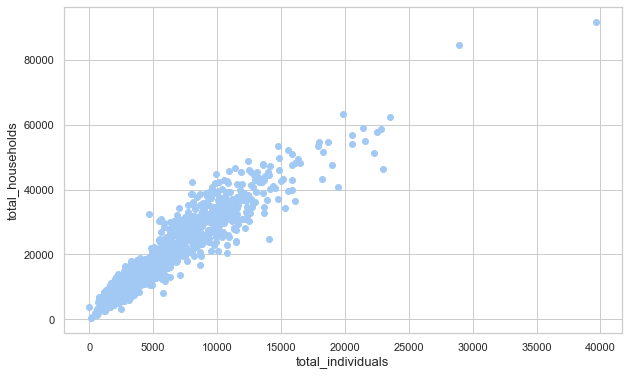

In [2068]:
fig, ax = plt.subplots()
ax.scatter(x = train['total_households'], y = train['total_individuals'])
plt.ylabel('total_households', fontsize=13)
plt.xlabel('total_individuals', fontsize=13)
plt.show()

We can see at the bottom right two with extremely large total_individuals that are of a low individual. These values are huge oultliers. Therefore, we can safely delete them.

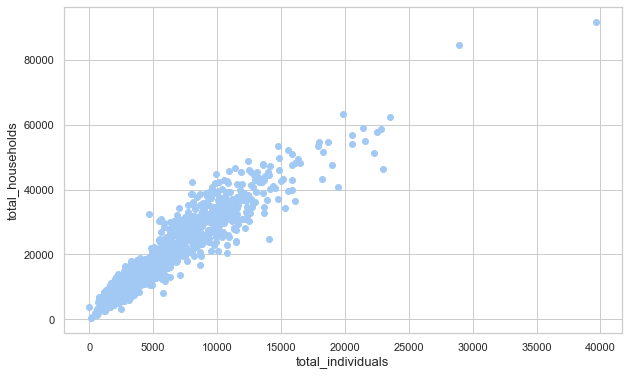

In [2069]:
#Deleting outliers
# train = train.drop(train[(train['total_individuals']>80000) & (train['total_households']>25000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = train['total_households'], y = train['total_individuals'])
plt.ylabel('total_households', fontsize=13)
plt.xlabel('total_individuals', fontsize=13)
plt.show()

### Note :
Outliers removal is note always safe. We decided to delete these two as they are very huge and really bad ( extremely large areas for very low prices).

There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. You can refer to the modelling part of this notebook for that.

### Target Variable

Target is the Percentage of women head households with income under R19.6k out of total number of households variable we need to predict. So let's do some analysis on this variable first.


 mu = 24.51 and sigma = 10.29



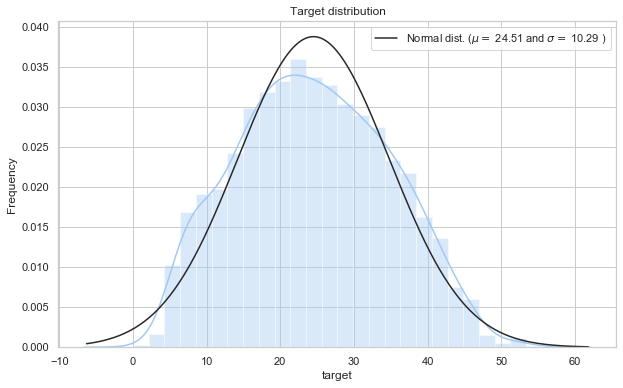

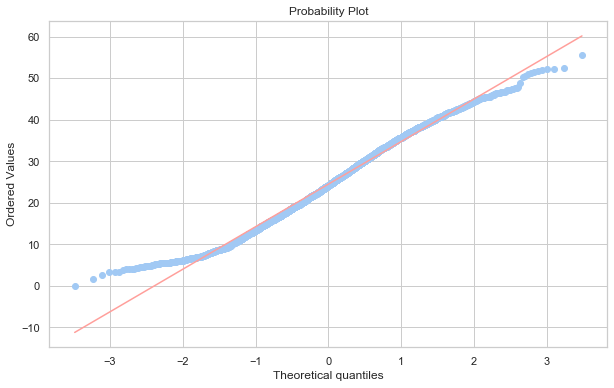

In [2070]:
sns.distplot(train['target'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Target distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['target'], plot=plt)
plt.show()

The target variable is (linear) models and lovely normally distributed data. The skew seems is corrected and the data appears more normally distributed.

## Features engineering

let's first concatenate the train and test data in the same dataframe

In [2071]:
ntrain = train.shape[0]
ntest = test.shape[0]
# y_train = train.target.values
all_data = pd.concat((train, test)).reset_index(drop=True)
# all_data.drop(['target'], axis=1, inplace=True)
print("ntrain size is : {}".format(ntrain))
print("ntest size is : {}".format(ntest))
print("all_data size is : {}".format(all_data.shape))

ntrain size is : 2822
ntest size is : 1013
all_data size is : (3835, 82)


In [2072]:
all_data.head()

,ADM0_EN,ADM0_PCODE,ADM1_EN,ADM1_ID,ADM1_PCODE,ADM1_TYPE,ADM2_EN,ADM2_ID,ADM2_PCODE,ADM2_TYPE,ADM3_EN,ADM3_ID,ADM3_PCODE,ADM3_REF,ADM3_TYPE,ADM4_EN,ADM4_PCODE,ADM4_TYPE,NL,SOURCE,car_00,car_01,coords,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,lat,lgt_00,lln_00,lln_01,lon,pg_00,pg_01,pg_02,pg_03,pg_04,psa_00,psa_01,psa_02,psa_03,psa_04,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,stv_00,stv_01,target,total_households,total_individuals,ward
0,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,001,ZA4161001,Ward No.,0.292,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.274,0.726,"[(24.696397002219953, -29.36626100224339), (24.69703699755945, -29.366284996155628), (24.720209999591873, -29.365164001117705), (24.72360199773408, -29.364999999850056), (24.725408999225976, -29.3...",0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.000,0.000,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.000,0.007,-29.682,0.919,0.119,0.881,24.735,0.357,0.563,0.004,0.073,0.002,0.260,0.608,0.000,0.010,0.122,0.743,0.214,0.020,0.003,0.008,0.000,0.013,0.000,0.000,0.283,0.717,16.774,1674.451,5888.208,41601001: Ward 1
1,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,002,ZA4161002,Ward No.,3.208,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.145,0.855,"[(24.76746281255879, -29.099032610266704), (24.77239899971414, -29.119713000054844), (24.772185136434928, -29.119635450615533), (24.772504554941293, -29.12095305094249), (24.77000244585622, -29.12...",0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.000,0.000,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.000,0.028,-29.119,0.959,0.067,0.933,24.758,0.698,0.278,0.004,0.016,0.004,0.290,0.550,0.000,0.021,0.139,0.309,0.577,0.019,0.015,0.057,0.019,0.004,0.000,0.000,0.104,0.896,21.497,1736.992,6735.338,41601002: Ward 2
2,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,003,ZA4161003,Ward No.,0.000,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.272,0.728,"[(24.797700001853627, -28.853749997364446), (24.81104000099532, -28.913079996744386), (24.83098999918917, -28.906760002072417), (24.84405000160632, -28.902619998214277), (24.85421999755488, -28.89...",0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.000,0.000,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.000,0.002,-29.142,0.826,0.100,0.900,25.094,0.672,0.154,0.002,0.167,0.004,0.186,0.677,0.000,0.021,0.115,0.323,0.483,0.083,0.058,0.010,0.001,0.041,0.000,0.000,0.166,0.834,10.931,2403.576,7273.050,41601003: Ward 3
3,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,004,ZA4161004,Ward No.,2.039,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.128,0.872,"[(24.98615100036841, -29.29077799990472), (25.000525999575245, -29.30170600023166), (25.007706999778293, -29.30716800030291), (25.015851000323437, -29.313360999910174), (25.01934699966438, -29.316...",0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.000,0.000,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.000,-29.372,0.986,0.029,0.971,24.943,0.728,0.264,0.002,0.001,0.005,0.281,0.593,0.001,0.007,0.118,0.677,0.314,0.003,0.000,0.001,0.000,0.005,0.000,0.000,0.088,0.912,23.119,1740.787,5734.490,41601004: Ward 4
4,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local M

### Missing Data

In [2073]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
target,26.415


In [2074]:
all_data['target'] = all_data['target'].fillna(all_data['target'].mode()[0])

In [2075]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [2076]:
train = train.drop(['pw_07','pw_08','dw_12','dw_13','lan_13'], axis=1)
test = test.drop(['pw_07','pw_08','dw_12','dw_13','lan_13'], axis=1)

# ['ADM1_EN','ADM2_EN','ADM3_EN','ADM4_EN']
train = train.drop(['ADM0_PCODE','ADM0_EN', 'ADM1_TYPE','ADM3_REF','ADM4_TYPE','SOURCE','coords'], axis=1)
test = test.drop(['ADM0_PCODE','ADM0_EN', 'ADM1_TYPE','ADM3_REF','ADM4_TYPE','SOURCE','coords'], axis=1)

all_data = all_data.drop(['pw_07','pw_08','dw_12','dw_13','lan_13'], axis=1)


In [2077]:
# all_data.shape
# mask = pd.notnull(['lln_00','lln_01'])
# all_data = all_data[mask]
# all_data.head()

### Data Correlation

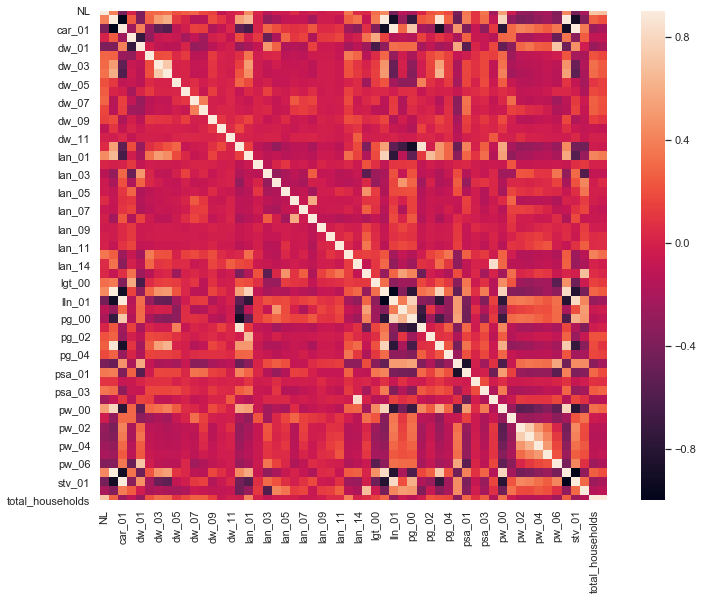

In [2078]:
#Correlation map to see how features are correlated with SalePrice
corrmat = all_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [2079]:
dwelling = ['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']
language = ['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']

street_ligh = ['lln_00','lln_01']

population = ['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']

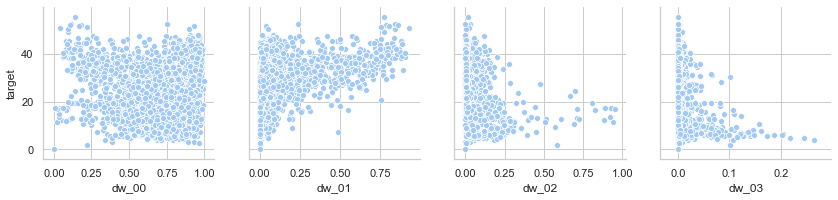

In [2080]:
sns.pairplot(train,
             y_vars= ['target'],
             x_vars=dwelling[:4],
             size=3)

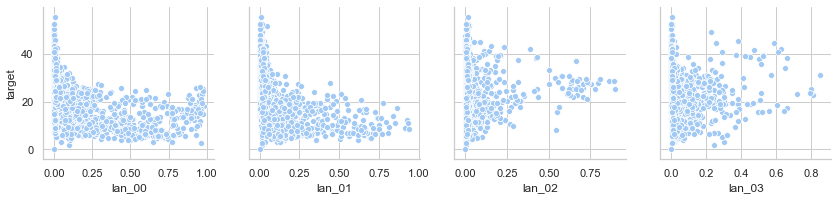

In [2081]:
sns.pairplot(train,
             y_vars= ['target'],
             x_vars=language[:4],
             size=3)

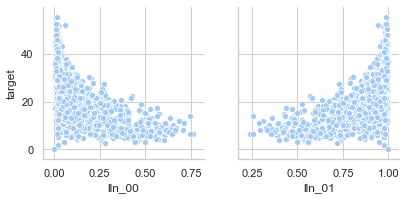

In [2082]:
sns.pairplot(train,
             y_vars= ['target'],
             x_vars=street_ligh[:4],
             size=3)

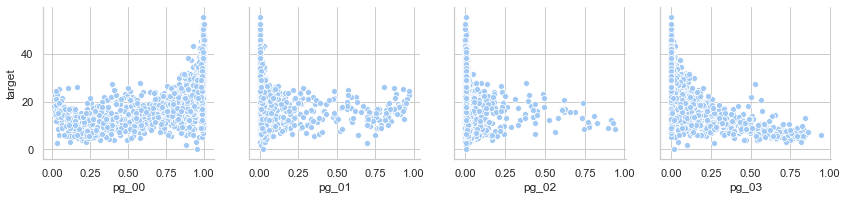

In [2083]:
sns.pairplot(train,
             y_vars= ['target'],
             x_vars=population[:4],
             size=3)

### Imputing missing values

We impute them by proceeding sequentially through features with missing values

### More features engeneering
Transforming some numerical variables that are really categorical

Label Encoding some categorical variables that may contain information in their ordering set

In [2084]:
all_data.columns

Index(['ADM0_EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_ID', 'ADM1_PCODE',
       'ADM1_TYPE', 'ADM2_EN', 'ADM2_ID', 'ADM2_PCODE', 'ADM2_TYPE', 'ADM3_EN',
       'ADM3_ID', 'ADM3_PCODE', 'ADM3_REF', 'ADM3_TYPE', 'ADM4_EN',
       'ADM4_PCODE', 'ADM4_TYPE', 'NL', 'SOURCE', 'car_00', 'car_01', 'coords',
       'dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'lan_00', 'lan_01', 'lan_02',
       'lan_03', 'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09',
       'lan_10', 'lan_11', 'lan_12', 'lan_14', 'lat', 'lgt_00', 'lln_00',
       'lln_01', 'lon', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'psa_00',
       'psa_01', 'psa_02', 'psa_03', 'psa_04', 'pw_00', 'pw_01', 'pw_02',
       'pw_03', 'pw_04', 'pw_05', 'pw_06', 'stv_00', 'stv_01', 'target',
       'total_households', 'total_individuals', 'ward'],
      dtype='object')

In [2085]:
all_data.head()

,ADM0_EN,ADM0_PCODE,ADM1_EN,ADM1_ID,ADM1_PCODE,ADM1_TYPE,ADM2_EN,ADM2_ID,ADM2_PCODE,ADM2_TYPE,ADM3_EN,ADM3_ID,ADM3_PCODE,ADM3_REF,ADM3_TYPE,ADM4_EN,ADM4_PCODE,ADM4_TYPE,NL,SOURCE,car_00,car_01,coords,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,lat,lgt_00,lln_00,lln_01,lon,pg_00,pg_01,pg_02,pg_03,pg_04,psa_00,psa_01,psa_02,psa_03,psa_04,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,stv_00,stv_01,target,total_households,total_individuals,ward
0,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,001,ZA4161001,Ward No.,0.292,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.274,0.726,"[(24.696397002219953, -29.36626100224339), (24.69703699755945, -29.366284996155628), (24.720209999591873, -29.365164001117705), (24.72360199773408, -29.364999999850056), (24.725408999225976, -29.3...",0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,-29.682,0.919,0.119,0.881,24.735,0.357,0.563,0.004,0.073,0.002,0.260,0.608,0.000,0.010,0.122,0.743,0.214,0.020,0.003,0.008,0.000,0.013,0.283,0.717,16.774,1674.451,5888.208,41601001: Ward 1
1,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,002,ZA4161002,Ward No.,3.208,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.145,0.855,"[(24.76746281255879, -29.099032610266704), (24.77239899971414, -29.119713000054844), (24.772185136434928, -29.119635450615533), (24.772504554941293, -29.12095305094249), (24.77000244585622, -29.12...",0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,-29.119,0.959,0.067,0.933,24.758,0.698,0.278,0.004,0.016,0.004,0.290,0.550,0.000,0.021,0.139,0.309,0.577,0.019,0.015,0.057,0.019,0.004,0.104,0.896,21.497,1736.992,6735.338,41601002: Ward 2
2,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,003,ZA4161003,Ward No.,0.000,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.272,0.728,"[(24.797700001853627, -28.853749997364446), (24.81104000099532, -28.913079996744386), (24.83098999918917, -28.906760002072417), (24.84405000160632, -28.902619998214277), (24.85421999755488, -28.89...",0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,-29.142,0.826,0.100,0.900,25.094,0.672,0.154,0.002,0.167,0.004,0.186,0.677,0.000,0.021,0.115,0.323,0.483,0.083,0.058,0.010,0.001,0.041,0.166,0.834,10.931,2403.576,7273.050,41601003: Ward 3
3,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,004,ZA4161004,Ward No.,2.039,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.128,0.872,"[(24.98615100036841, -29.29077799990472), (25.000525999575245, -29.30170600023166), (25.007706999778293, -29.30716800030291), (25.015851000323437, -29.313360999910174), (25.01934699966438, -29.316...",0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,-29.372,0.986,0.029,0.971,24.943,0.728,0.264,0.002,0.001,0.005,0.281,0.593,0.001,0.007,0.118,0.677,0.314,0.003,0.000,0.001,0.000,0.005,0.088,0.912,23.119,1740.787,5734.490,41601004: Ward 4
4,South Africa,ZA,Free State,FS,ZA4,Province,Xhariep,DC16,ZA416,District Municipality,Letsemeng,FS161,ZA4161,Letsemeng,Local Municipality,005,ZA4161005,Ward No.,0.000,Municipal Demarcation Board 2016 boundaries cleaned by UN OCHA,0.405,0.595,"[(25.38981399581928, -29.139918999

In [2086]:
# from sklearn.preprocessing import LabelEncoder
# cols = ('ADM4_PCODE', 'ward')
# # process columns, apply LabelEncoder to categorical features
# for c in cols:
#     lbl = LabelEncoder() 
#     lbl.fit(list(all_data[c].values)) 
#     all_data[c] = lbl.transform(list(all_data[c].values))

# # shape        
# print('Shape all_data: {}'.format(all_data.shape))

# all_data = all_data.drop(['ward','ADM4_PCODE'], axis=1)

#### Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [2087]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,ZA4161001,-29.682,24.735,0.292,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,001
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,ZA4161002,-29.119,24.758,3.208,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,002
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,ZA4161003,-29.142,25.094,0.000,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,003
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,ZA4161004,-29.372,24.943,2.039,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,004
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,ZA4161005,-29.409,25.290,0.000,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,005


In [2088]:
# # Average household size - might contain some useful information
# all_data['average_household_Size'] =all_data['total_individuals']/all_data['total_households']

# # Average household size - might contain some useful information
# train['average_household_Size'] = train['total_individuals']/train['total_households']
# test['average_household_Size'] = test['total_individuals']/test['total_households']

# # items_popularity['popularity_scale_10'] = np.array(np.round((items_popularity['pop_percent'] * 10)), dtype='int')

# train['average_household_popularity_scale_100'] = np.array(np.round((train['average_household_Size']), 6), dtype='float')
# test['average_household_popularity_scale_100'] = np.array(np.round((test['average_household_Size']), 6), dtype='float')

# train['total_car_average'] = ((train['car_00'] - train['car_01'])/((train['car_00'] + train['car_01']).mean()))
# train['total_car_average']  =  abs(train['total_car_average'] )

# test['total_car_average'] = ((test['car_00'] - test['car_01'])/((test['car_00'] + test['car_01']).mean()))
# test['total_car_average'] =  abs(test['total_car_average'])


# train['total_lan_average'] =  (train['lan_00'] - train['lan_01'] - train['lan_02'] - train['lan_03'] - train['lan_04'] - train['lan_05'] - train['lan_06'] -

#                                 train['lan_07'] - train['lan_08'] - train['lan_09'] - train['lan_10'] - train['lan_11'] - train['lan_12'] - train['lan_14'])/((train['lan_00'] + train['lan_01'] + train['lan_02'] + train['lan_03'] + train['lan_04'] + train['lan_05'] + train['lan_06'] +

#                                 train['lan_07'] + train['lan_08'] + train['lan_09'] + train['lan_10'] + train['lan_11'] + train['lan_12'] + train['lan_14']).mean())

# train['total_lan_average'] = abs(train['total_lan_average'])

# test['total_lan_average'] =  (test['lan_00'] - test['lan_01'] - test['lan_02'] - test['lan_03'] - test['lan_04'] - test['lan_05'] - test['lan_06'] -
# test['lan_07'] - test['lan_08'] - test['lan_09'] - test['lan_10'] - test['lan_11'] - test['lan_12'] - test['lan_14']) / ((test['lan_00'] + test['lan_01'] + test['lan_02'] + test['lan_03'] + test['lan_04'] + test['lan_05'] + test['lan_06'] +
# test['lan_07'] + test['lan_08'] + test['lan_09'] + test['lan_10'] + test['lan_11'] + test['lan_12'] + test['lan_14']).mean())
# test['total_lan_average'] = abs(test['total_lan_average'])


# train['total_dw_average'] = (train['dw_00'] - train['dw_01'] - train['dw_02'] - train['dw_03'] - train['dw_04'] - train['dw_05'] - train['dw_06'] - train['dw_07'] -
# train['dw_08'] - train['dw_09'] - train['dw_10'] - train['dw_11']) / ((train['dw_00'] + train['dw_01'] + train['dw_02'] + train['dw_03'] + train['dw_04'] + train['dw_05'] + train['dw_06'] + train['dw_07'] +
# train['dw_08'] + train['dw_09'] + train['dw_10'] + train['dw_11']).mean())
# train['total_dw_average'] = abs(train['total_dw_average'])

# test['total_dw_average'] = (test['dw_00'] - test['dw_01'] - test['dw_02'] - test['dw_03'] - test['dw_04'] - test['dw_05'] - test['dw_06'] + test['dw_07'] +
# test['dw_08'] - test['dw_09'] - test['dw_10'] - test['dw_11']) / ((test['dw_00'] + test['dw_01'] + test['dw_02'] + test['dw_03'] + test['dw_04'] + test['dw_05'] + test['dw_06'] + test['dw_07'] +
# test['dw_08'] + test['dw_09'] + test['dw_10'] + test['dw_11']).mean())
# test['total_dw_average'] = abs(test['total_dw_average'])



# train['total_landline_average'] = (train['lln_00'] - train['lln_01'])/((train['lln_00'] + train['lln_01']).mean())
# train['total_landline_average'] = abs(train['total_landline_average'])

# test['total_landline_average'] = (test['lln_00'] - test['lln_01'])/((test['lln_00'] + test['lln_01']).mean())
# test['total_landline_average'] = abs(test['total_landline_average'])


# train['total_saterlite_average'] = (train['stv_00'] - train['stv_01'])/((train['stv_00'] + train['stv_01']).mean())
# train['total_saterlite_average'] = abs(train['total_saterlite_average'])


# test['total_saterlite_average'] =  (test['stv_00'] - test['stv_01'])/((test['stv_00'] + test['stv_01']).mean())
# test['total_saterlite_average'] = abs(test['total_saterlite_average'])

# train['total_population_group_average'] = (train['pg_00'] - train['pg_01'] - train['pg_02'] - train['pg_03'] - train['pg_04'])/((train['pg_00'] + train['pg_01'] + train['pg_02'] + train['pg_03'] + train['pg_04']).mean())
# train['total_population_group_average'] = abs(train['total_population_group_average'])


# test['total_population_group_average'] = (test['pg_00'] - test['pg_01'] - test['pg_02'] - test['pg_03'] - test['pg_04'])/((test['pg_00'] + test['pg_01'] + test['pg_02'] + test['pg_03'] + test['pg_04']).mean())
# test['total_population_group_average'] = abs(test['total_population_group_average'])


# train['total_school_attendance_average'] = (train['psa_00'] - train['psa_01'] - train['psa_02'] - train['psa_03'] - train['psa_04'])/((train['psa_00'] + train['psa_01'] + train['psa_02'] + train['psa_03'] + train['psa_04']).mean())
# train['total_school_attendance_average'] = abs(train['total_school_attendance_average'])


# test['total_school_attendance_average'] = (test['psa_00'] - test['psa_01'] - test['psa_02'] - test['psa_03'] - test['psa_04']) / ((test['psa_00'] + test['psa_01'] + test['psa_02'] + test['psa_03'] + test['psa_04']).mean())
# test['total_school_attendance_average'] = abs(test['total_school_attendance_average'])


# train['total_piped_water_access_average'] = (train['pw_00'] - train['pw_01'] - train['pw_02'] - train['pw_03'] - train['pw_04'] - train['pw_05'] - train['pw_06'])/((train['pw_00'] +train['pw_01'] + train['pw_02'] + train['pw_03'] + train['pw_04'] + train['pw_05'] + train['pw_06']).mean())
# train['total_piped_water_access_average'] = abs(train['total_piped_water_access_average'])


# test['total_piped_water_access_average'] = (test['pw_00'] - test['pw_01'] - test['pw_02'] - test['pw_03'] - test['pw_04'] - test['pw_05'] - test['pw_06'])/((test['pw_00'] + test['pw_01'] + test['pw_02'] + test['pw_03'] + test['pw_04'] + test['pw_05'] + test['pw_06']).mean())
# test['total_piped_water_access_average'] = abs(test['total_piped_water_access_average'] )


### Ways to deal with longitude/latitude feature

###### https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature

Lat long coordinates have a problem that they are 2 features that represent a three dimensional space. This means that the long coordinate goes all around, which means the two most extreme values are actually very close together. I've dealt with this problem a few times and what I do in this case is map them to x, y and z coordinates. This means close points in these 3 dimensions are also close in reality. Depending on the use case you can disregard the changes in height and map them to a perfect sphere. These features can then be standardized properly.

To clarify (summarised from the comments):

In [2089]:
train['x_cordinate'] = abs(np.cos(train['lat']) * np.cos(train['lon']))
train['y_cordinate'] = abs(np.cos(train['lat']) * np.sin(train['lat']))
train['z_cordinate'] = abs(np.sin(train['lat']))
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,ZA4161001,-29.682,24.735,0.292,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,001,0.149,0.160,0.987
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,ZA4161002,-29.119,24.758,3.208,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,002,0.618,0.496,0.748
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,ZA4161003,-29.142,25.094,0.000,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,003,0.646,0.493,0.763
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,ZA4161004,-29.372,24.943,2.039,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,004,0.447,0.406,0.890
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,ZA4161005,-29.409,25.290,0.000,ZA4,FS,Free State,ZA416,DC16,Xhariep,District Municipality,ZA4161,FS161,Letsemeng,Local Municipality,005,0.417,0.383,0.907


In [2090]:
test['x_cordinate'] = abs(np.cos(test['lat']) * np.cos(test['lon']))
test['y_cordinate'] = abs(np.cos(test['lat']) * np.sin(test['lat'])) 
test['z_cordinate'] = abs(np.sin(test['lat']))
test.head()

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,21001001: Ward 1,2504.952,8745.152,0.947,0.001,0.002,0.000,0.000,0.030,0.000,0.013,0.004,0.000,0.001,0.002,0.247,0.615,0.000,0.017,0.121,0.155,0.845,0.217,0.783,0.174,0.826,0.818,0.023,0.001,0.126,0.000,0.000,0.003,0.006,0.000,0.000,0.000,0.000,0.005,0.019,0.173,0.736,0.004,0.083,0.004,0.921,0.552,0.427,0.012,0.002,0.000,0.000,0.007,ZA2101001,-32.638,23.849,0.000,ZA2,EC,Eastern Cape,ZA210,DC10,Cacadu,District Municipality,ZA2101,EC101,Dr Beyers Naude,Local Municipality,001,0.097,0.321,0.940
1,21001002: Ward 2,2080.277,7258.118,0.845,0.000,0.044,0.005,0.012,0.012,0.022,0.022,0.017,0.007,0.006,0.007,0.193,0.532,0.001,0.053,0.221,0.406,0.594,0.499,0.501,0.367,0.633,0.435,0.106,0.000,0.289,0.001,0.001,0.002,0.003,0.001,0.000,0.000,0.000,0.006,0.154,0.471,0.192,0.003,0.325,0.009,0.955,0.760,0.227,0.010,0.001,0.000,0.000,0.003,ZA2101002,-31.991,24.556,0.000,ZA2,EC,Eastern Cape,ZA210,DC10,Cacadu,District Municipality,ZA2101,EC101,Dr Beyers Naude,Local Municipality,002,0.704,0.456,0.544
2,21001003: Ward 3,1106.626,5919.132,0.651,0.008,0.007,0.000,0.002,0.260,0.007,0.044,0.014,0.000,0.000,0.008,0.296,0.499,0.011,0.079,0.115,0.237,0.763,0.190,0.810,0.090,0.910,0.953,0.015,0.000,0.018,0.001,0.000,0.002,0.001,0.003,0.002,0.001,0.000,0.003,0.000,0.080,0.915,0.002,0.001,0.003,0.976,0.704,0.292,0.002,0.002,0.000,0.000,0.000,ZA2101003,-32.284,24.564,8.270,ZA2,EC,Eastern Cape,ZA210,DC10,Cacadu,District Municipality,ZA2101,EC101,Dr Beyers Naude,Local Municipality,003,0.545,0.493,0.763
3,21001004: Ward 4,2175.561,10280.575,0.411,0.002,0.012,0.000,0.000,0.450,0.009,0.102,0.002,0.009,0.000,0.003,0.265,0.519,0.000,0.014,0.201,0.343,0.657,0.348,0.652,0.249,0.751,0.852,0.021,0.001,0.018,0.000,0.001,0.001,0.005,0.001,0.000,0.000,0.000,0.001,0.099,0.102,0.833,0.007,0.055,0.003,0.966,0.556,0.440,0.002,0.000,0.001,0.000,0.001,ZA2101004,-32.262,24.542,8.627,ZA2,EC,Eastern Cape,ZA210,DC10,Cacadu,District Municipality,ZA2101,EC101,Dr Beyers Naude,Local Municipality,004,0.551,0.496,0.748
4,21001005: Ward 5,1270.839,6018.342,0.943,0.003,0.001,0.000,0.001,0.001,0.001,0.028,0.002,0.017,0.000,0.004,0.285,0.552,0.000,0.053,0.109,0.256,0.744,0.182,0.818,0.138,0.862,0.966,0.012,0.000,0.011,0.001,0.000,0.002,0.005,0.001,0.000,0.001,0.000,0.002,0.000,0.034,0.957,0.007,0.000,0.003,0.952,0.444,0.553,0.001,0.000,0.000,0.000,0.002,ZA2101005,-32.252,24.559,8.602,ZA2,EC,Eastern Cape,ZA210,DC10,Cacadu,District Municipality,ZA2101,EC101,Dr Beyers Naude,Local Municipality,005,0.563,0.497,0.742


### Skewed features

In [2091]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
dw_11,27.534
pg_04,17.032
dw_10,9.945
lan_14,8.864
pg_02,8.707
psa_04,8.000
lan_09,7.990
lan_10,7.848
psa_02,7.709
dw_09,7.584


### Box Cox Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.

See this page for more details on Box Cox Transformation as well as the scipy function's page

In [2092]:
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     #all_data[feat] += 1
#     all_data[feat] = boxcox1p(all_data[feat], lam)
    
# #all_data[skewed_features] = np.log1p(all_data[skewed_features])

#### Getting dummy categorical features

In [2093]:
train.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'ADM1_PCODE', 'ADM1_ID', 'ADM1_EN', 'ADM2_PCODE', 'ADM2_ID',
       'ADM2_EN', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_TYPE',
       'ADM4_EN', 'x_cordinate', 'y_cordinate', 'z_cordinate'],
      dtype='object')

In [2094]:
from sklearn.preprocessing import LabelEncoder
# ['ADM1_EN','ADM2_EN','ADM3_EN','ADM4_EN']

train['ADM1_PCODE'] = preprocessing.LabelEncoder().fit_transform(train['ADM1_PCODE'])
train['ADM1_ID'] = preprocessing.LabelEncoder().fit_transform(train['ADM1_ID'])
train['ADM2_PCODE'] = preprocessing.LabelEncoder().fit_transform(train['ADM2_PCODE'])
train['ADM2_ID'] = preprocessing.LabelEncoder().fit_transform(train['ADM2_ID'])
train['ADM2_TYPE'] = preprocessing.LabelEncoder().fit_transform(train['ADM2_TYPE'])
train['ADM3_PCODE'] = preprocessing.LabelEncoder().fit_transform(train['ADM3_PCODE'])
train['ADM3_ID'] = preprocessing.LabelEncoder().fit_transform(train['ADM3_ID'])
train['ADM3_TYPE'] = preprocessing.LabelEncoder().fit_transform(train['ADM3_TYPE'])
train['ADM1_EN'] = preprocessing.LabelEncoder().fit_transform(train['ADM1_EN'])
train['ADM2_EN'] = preprocessing.LabelEncoder().fit_transform(train['ADM2_EN'])
train['ADM3_EN'] = preprocessing.LabelEncoder().fit_transform(train['ADM3_EN'])
train['ADM4_EN'] = preprocessing.LabelEncoder().fit_transform(train['ADM4_EN'])



# train_df_le['ward'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ward'])
# train_df_le['ADM4_PCODE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM4_PCODE'])



test['ADM1_PCODE'] = preprocessing.LabelEncoder().fit_transform(test['ADM1_PCODE'])
test['ADM1_ID'] = preprocessing.LabelEncoder().fit_transform(test['ADM1_ID'])
test['ADM2_PCODE'] = preprocessing.LabelEncoder().fit_transform(test['ADM2_PCODE'])
test['ADM2_ID'] = preprocessing.LabelEncoder().fit_transform(test['ADM2_ID'])
test['ADM2_TYPE'] = preprocessing.LabelEncoder().fit_transform(test['ADM2_TYPE'])
test['ADM3_PCODE'] = preprocessing.LabelEncoder().fit_transform(test['ADM3_PCODE'])
test['ADM3_ID'] = preprocessing.LabelEncoder().fit_transform(test['ADM3_ID'])
test['ADM3_TYPE'] = preprocessing.LabelEncoder().fit_transform(test['ADM3_TYPE'])
test['ADM1_EN'] = preprocessing.LabelEncoder().fit_transform(test['ADM1_EN'])
test['ADM2_EN'] = preprocessing.LabelEncoder().fit_transform(test['ADM2_EN'])
test['ADM3_EN'] = preprocessing.LabelEncoder().fit_transform(test['ADM3_EN'])
test['ADM4_EN'] = preprocessing.LabelEncoder().fit_transform(test['ADM4_EN'])

# test_df_le['ward'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ward'])
# test_df_le['ADM4_PCODE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM4_PCODE'])


In [2095]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,ZA4161001,-29.682,24.735,0.292,1,0,0,5,0,33,0,25,2,53,0,0,0.149,0.160,0.987
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,ZA4161002,-29.119,24.758,3.208,1,0,0,5,0,33,0,25,2,53,0,1,0.618,0.496,0.748
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,ZA4161003,-29.142,25.094,0.000,1,0,0,5,0,33,0,25,2,53,0,2,0.646,0.493,0.763
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,ZA4161004,-29.372,24.943,2.039,1,0,0,5,0,33,0,25,2,53,0,3,0.447,0.406,0.890
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,ZA4161005,-29.409,25.290,0.000,1,0,0,5,0,33,0,25,2,53,0,4,0.417,0.383,0.907


In [2200]:
ct = train[train.iloc[:,2] < train.iloc[:,1]]
if (len(ct.index) == 0):
    print("all")

all


In [2217]:
all_district = "All districts"

print(all_district.strip(""))
map(str, my_lst)

All districts


Getting the new train and test sets.

In [2097]:
# train_df_le.columns
categorical_features_indices = np.where(train.dtypes != np.float)[0]
categorical_features_indices

array([ 0, 54, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
      dtype=int64)

In [2209]:
train['que'] = np.where((train['total_individuals'] >= train['total_households']) & (train['total_individuals'] <= train['total_households']), train['ward'], np.nan)
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate,que
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,ZA4161001,-29.682,24.735,0.292,1,0,0,5,0,33,0,25,2,53,0,0,0.149,0.160,0.987,NaN
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,ZA4161002,-29.119,24.758,3.208,1,0,0,5,0,33,0,25,2,53,0,1,0.618,0.496,0.748,NaN
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,ZA4161003,-29.142,25.094,0.000,1,0,0,5,0,33,0,25,2,53,0,2,0.646,0.493,0.763,NaN
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,ZA4161004,-29.372,24.943,2.039,1,0,0,5,0,33,0,25,2,53,0,3,0.447,0.406,0.890,NaN
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,ZA4161005,-29.409,25.290,0.000,1,0,0,5,0,33,0,25,2,53,0,4,0.417,0.383,0.907,NaN


In [2211]:
if (len(train['que'].index)==0):
    

False

In [2098]:

trainCol = train.columns

obj_column = []

for column in trainCol:
    if(train[column].dtypes == 'int'):
        obj_column.append(column)
        
print(obj_column)

['ADM1_PCODE', 'ADM1_ID', 'ADM1_EN', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_TYPE', 'ADM4_EN']


In [2099]:
train.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'ADM1_PCODE', 'ADM1_ID', 'ADM1_EN', 'ADM2_PCODE', 'ADM2_ID',
       'ADM2_EN', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_TYPE',
       'ADM4_EN', 'x_cordinate', 'y_cordinate', 'z_cordinate'],
      dtype='object')

In [2100]:
# train_df[:] = np.nan_to_num(train_df)
# train_df[train_df==np.inf]=np.nan
# train_df.fillna(train_df.mean(), inplace=True)

In [2101]:
# test_df[:] = np.nan_to_num(test_df)
# test_df[test_df==np.inf]=np.nan
# test_df.fillna(test_df.mean(), inplace=True)

In [2102]:
# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

# train_df = clean_dataset(train_df)
# train_df = clean_dataset(train_df)


# print(np.any(np.isfinite(train_df)))
# train_df = train_df.astype(np.float64)
# print(np.any(np.isfinite(test_df)))
# test_df = test_df.astype(np.float64)
# print(train_df.dtypes, test_df.dtypes)

In [2103]:
# train_df = train_df.astype('object')
# test_df = test_df.astype('object')

# train_df = train_df.reset_index()
# test_df = test_df.reset_index()

In [2104]:
train = train.fillna(train.mean())
test =test.fillna(test.mean())

In [2105]:
# print(np.all(np.isfinite(train)))

In [2106]:
# train_df['NL'].fillna(train_df['NL'].median(), inplace=True)
# train_df['car_00'].fillna(train_df['car_00'].median(), inplace=True)
# train_df['car_01'].fillna(train_df['car_01'].median(), inplace=True)
# train_df['stv_00'].fillna(train_df['stv_00'].median(), inplace=True)
# train_df['stv_01'].fillna(train_df['stv_01'].median(), inplace=True)

# train_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].fillna(train_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].median(), inplace=True)
# train_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].fillna(train_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].median(), inplace=True)

# train_df['lgt_00'].fillna(train_df['lgt_00'].median(), inplace=True)

# train_df['lat'].fillna(train_df['lat'].median(), inplace=True)
# train_df['lon'].fillna(train_df['lon'].median(), inplace=True)
 
# train_df[['lln_00','lln_01']].fillna(train_df[['lln_00','lln_01']].median(), inplace=True)

# train_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']].fillna(train_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']].median(), inplace=True)


# train_df[['stv_00','stv_01','target','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].fillna(train_df[['stv_00','stv_01','target','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].median(), inplace=True)




In [2107]:
# test_df['NL'].fillna(test_df['NL'].median(), inplace=True)
# test_df['car_00'].fillna(test_df['car_00'].median(), inplace=True)
# test_df['car_01'].fillna(test_df['car_01'].median(), inplace=True)
# test_df['stv_00'].fillna(test_df['stv_00'].median(), inplace=True)
# test_df['stv_01'].fillna(test_df['stv_01'].median(), inplace=True)

# test_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].fillna(test_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].median(), inplace=True)
# test_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].fillna(test_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].median(), inplace=True)

# test_df['lgt_00'].fillna(test_df['lgt_00'].median(), inplace=True)

# test_df['lat'].fillna(test_df['lat'].median(), inplace=True)
# test_df['lon'].fillna(test_df['lon'].median(), inplace=True)
 
# test_df[['lln_00','lln_01']].fillna(test_df[['lln_00','lln_01']].median(), inplace=True)

# test_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']].fillna(test_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']].median(), inplace=True)


# test_df[['stv_00','stv_01','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].fillna(test_df[['stv_00','stv_01','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].median(), inplace=True)



In [2108]:
# #replace: np.inf, -np.inf
print("Check if isfinite")
train_df = train_df.replace([np.inf, -np.inf], [train_df.mode(),train_df.mode()])
test_df = test_df.replace([np.inf, -np.inf], [test_df.mode(),test_df.mode()])


Check if isfinite


In [2109]:
# train_df['NL'] = train_df['NL'].replace([np.inf, -np.inf], [train_df['NL'].mode(),train_df['NL'].mode()])
# train_df['car_00'] = train_df['car_00'].replace([np.inf, -np.inf],[train_df['car_00'].mode(),train_df['car_00'].mode()])
# train_df['car_01'] = train_df['car_01'].replace([np.inf, -np.inf],[train_df['car_01'].mode(),train_df['car_01'].mode()])

# train_df['stv_00'] = train_df['stv_00'].replace([np.inf, -np.inf],[train_df['stv_00'].mode(),train_df['stv_00'].mode()])
# train_df['stv_01'] = train_df['stv_01'].replace([np.inf, -np.inf],[train_df['stv_01'].mode(),train_df['stv_01'].mode()])

# train_df['lat'] = train_df['lat'].replace([np.inf, -np.inf],[train_df['lat'].mode(),train_df['lat'].mode()])
# train_df['lon'] = train_df['lon'].replace([np.inf, -np.inf],[train_df['lon'].mode(),train_df['lon'].mode()])
 
# train_df[['lln_00','lln_01']] = train_df[['lln_00','lln_01']].replace([np.inf, -np.inf],[train_df[['lln_00','lln_01']].mode(),train_df[['lln_00','lln_01']].mode()])


# train_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']] = train_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].replace([np.inf, -np.inf],[train_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].mode(),train_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].mode()])

# train_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']] = train_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].replace([np.inf, -np.inf],[train_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].mode(),train_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].mode()])

# train_df['lgt_00'] = train_df['lgt_00'].replace([np.inf, -np.inf],[train_df['lgt_00'].mode(),train_df['lgt_00'].mode()])



# train_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']] = train_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']].replace([np.inf, -np.inf],[train_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']] .mode(),train_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']] .mode()])


# train_df[['stv_00','stv_01','target', 'total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']] = train_df[['stv_00','stv_01','target', 'total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].replace([np.inf, -np.inf],[train_df[['stv_00','stv_01','target', 'total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].mode(),train_df[['stv_00','stv_01','target', 'total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].mode()])



In [2110]:
# test_df['NL'] = test_df['NL'].replace([np.inf, -np.inf], [test_df['NL'].mode(),test_df['NL'].mode()])
# test_df['car_00'] = test_df['car_00'].replace([np.inf, -np.inf],[test_df['car_00'].mode(),test_df['car_00'].mode()])
# test_df['car_01'] = test_df['car_01'].replace([np.inf, -np.inf],[test_df['car_01'].mode(),test_df['car_01'].mode()])

# test_df['stv_00'] = test_df['stv_00'].replace([np.inf, -np.inf],[test_df['stv_00'].mode(),test_df['stv_00'].mode()])
# test_df['stv_01'] = test_df['stv_01'].replace([np.inf, -np.inf],[test_df['stv_01'].mode(),test_df['stv_01'].mode()])

# test_df['lat'] = test_df['lat'].replace([np.inf, -np.inf],[test_df['lat'].mode(),test_df['lat'].mode()])
# test_df['lon'] = test_df['lon'].replace([np.inf, -np.inf],[test_df['lon'].mode(),test_df['lon'].mode()])
 
# test_df[['lln_00','lln_01']] = test_df[['lln_00','lln_01']].replace([np.inf, -np.inf],[test_df[['lln_00','lln_01']].mode(),test_df[['lln_00','lln_01']].mode()])


# test_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']] = test_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].replace([np.inf, -np.inf],[test_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].mode(),test_df[['dw_00', 'dw_01','dw_02','dw_03','dw_04','dw_05','dw_06', 'dw_07','dw_08', 'dw_09','dw_10','dw_11']].mode()])

# test_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']] = test_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].replace([np.inf, -np.inf],[test_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].mode(),test_df[['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']].mode()])

# test_df['lgt_00'] = test_df['lgt_00'].replace([np.inf, -np.inf],[test_df['lgt_00'].mode(),test_df['lgt_00'].mode()])



# test_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']] = test_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']].replace([np.inf, -np.inf],[test_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']] .mode(),test_df[['pg_00','pg_01','pg_02','pg_03','pg_04','psa_00','psa_01','psa_02','psa_03','psa_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']] .mode()])


# test_df[['stv_00','stv_01','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']] = test_df[['stv_00','stv_01','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].replace([np.inf, -np.inf],[test_df[['stv_00','stv_01','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].mode(),test_df[['stv_00','stv_01','total_households','total_individuals','average_household_Size','average_household_popularity_scale_100','total_car','total_lan','total_dw','total_landline','total_saterlite','total_population_group','total_school_attendance','total_piped_water_access']].mode()])



In [2111]:
# train_df = train_df.replace('nan',0)
# test_df =  test_df.replace('nan',0)

# train_df = train_df.fillna(train_df.median()).clip(-1e11,1e11)
# test_df = test_df.fillna(test_df.median()).clip(-1e11,1e11)

In [2112]:
# import numpy.ma as ma
# x = train_df.drop('target', axis=1)
# A = x.values
# np.where(np.isnan(A), ma.array(A, mask=np.isnan(A)).mean(axis=0), A)

In [2113]:
# chosen_cols = np.random.choice(train_df.columns,66,replace=False).tolist()
# chosen_cols

In [2114]:
# y = train_df.target
# X = train_df.drop('target', axis=1)
# # X.fillna(X.mode())
# # y.fillna(y.mode())

# # X=np.array(x)
# # y=np.array(y)
# # test_df = np.array(test_df)
# print(X.shape)
# print(y.shape)

# X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.15)


# # print(X_train.shape, X_test.shape)
# # print(y_train.shape,y_test.shape)

In [2115]:
# y = np.nan_to_num(y)
# X = np.nan_to_num(X)
# test_data = np.nan_to_num(test_df)

### Explorer Categorical feautured

In [2116]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,ZA4161001,-29.682,24.735,0.292,1,0,0,5,0,33,0,25,2,53,0,0,0.149,0.160,0.987
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,ZA4161002,-29.119,24.758,3.208,1,0,0,5,0,33,0,25,2,53,0,1,0.618,0.496,0.748
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,ZA4161003,-29.142,25.094,0.000,1,0,0,5,0,33,0,25,2,53,0,2,0.646,0.493,0.763
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,ZA4161004,-29.372,24.943,2.039,1,0,0,5,0,33,0,25,2,53,0,3,0.447,0.406,0.890
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,ZA4161005,-29.409,25.290,0.000,1,0,0,5,0,33,0,25,2,53,0,4,0.417,0.383,0.907


In [2117]:
# text columns
texto = train.dtypes ==object
raw_text_cols_train = [c for c in texto.index if texto[c]]
raw_text_cols_train

# text columns
texto = test.dtypes ==object
raw_text_cols_test = [c for c in texto.index if texto[c]]
raw_text_cols_test

['ward', 'ADM4_PCODE']

In [2118]:
# get just number columns
num =(train.dtypes == float) | (train.dtypes==np.int64)
raw_num_cols_train = [c for c in num.index if num[c]]
raw_num_cols_train
# get just number columns
num =(test.dtypes == float) | (test.dtypes==np.int64)
raw_num_cols_test = [c for c in num.index if num[c]]
# raw_num_cols_test

In [2119]:
#explorer categorical (text) columns 
train[raw_text_cols_train].apply(pd.Series.nunique).sort_values()
test[raw_text_cols_test].apply(pd.Series.nunique).sort_values()

ward          1013
ADM4_PCODE    1013
dtype: int64

In [2120]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,ZA4161001,-29.682,24.735,0.292,1,0,0,5,0,33,0,25,2,53,0,0,0.149,0.160,0.987
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,ZA4161002,-29.119,24.758,3.208,1,0,0,5,0,33,0,25,2,53,0,1,0.618,0.496,0.748
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,ZA4161003,-29.142,25.094,0.000,1,0,0,5,0,33,0,25,2,53,0,2,0.646,0.493,0.763
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,ZA4161004,-29.372,24.943,2.039,1,0,0,5,0,33,0,25,2,53,0,3,0.447,0.406,0.890
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,ZA4161005,-29.409,25.290,0.000,1,0,0,5,0,33,0,25,2,53,0,4,0.417,0.383,0.907


In [2121]:
train.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'ADM1_PCODE', 'ADM1_ID', 'ADM1_EN', 'ADM2_PCODE', 'ADM2_ID',
       'ADM2_EN', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_TYPE',
       'ADM4_EN', 'x_cordinate', 'y_cordinate', 'z_cordinate'],
      dtype='object')

In [2122]:
def count_unique(df, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(df[col].value_counts())
        
count_unique(train,raw_num_cols_train)


For column total_households
7068.047     1
1951.793     1
1556.938     1
2086.091     1
5698.450     1
            ..
2019.635     1
9577.944     1
12280.923    1
4369.070     1
178.000      1
Name: total_households, Length: 2822, dtype: int64

For column total_individuals
8790.173     1
32680.491    1
9587.481     1
10231.009    1
3412.419     1
            ..
12991.692    1
7851.909     1
6889.922     1
6271.993     1
16686.473    1
Name: total_individuals, Length: 2822, dtype: int64

For column target
10.317    1
31.665    1
21.917    1
22.397    1
27.363    1
         ..
30.770    1
19.793    1
18.927    1
6.940     1
0.000     1
Name: target, Length: 2822, dtype: int64

For column dw_00
0.638    1
0.801    1
0.824    1
0.449    1
0.710    1
        ..
0.910    1
0.382    1
0.845    1
0.681    1
0.000    1
Name: dw_00, Length: 2822, dtype: int64

For column dw_01
0.000    88
0.896     1
0.001     1
0.002     1
0.208     1
         ..
0.049     1
0.082     1
0.204     1
0.103     1

Name: y_cordinate, Length: 2822, dtype: int64

For column z_cordinate
0.148    1
0.577    1
0.947    1
0.664    1
0.577    1
        ..
0.877    1
0.275    1
0.945    1
0.764    1
0.678    1
Name: z_cordinate, Length: 2822, dtype: int64


In [2123]:
def count_unique(df, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(df[col].value_counts())
        
count_unique(test,raw_num_cols_test)


For column total_households
1752.558    1
1727.384    1
7800.055    1
2391.156    1
2089.664    1
           ..
2558.690    1
3590.989    1
1900.736    1
2261.043    1
3069.368    1
Name: total_households, Length: 1013, dtype: int64

For column total_individuals
12445.956    1
7279.575     1
10211.561    1
14928.398    1
5862.119     1
            ..
22606.576    1
6463.060     1
7207.508     1
7612.308     1
28528.565    1
Name: total_individuals, Length: 1013, dtype: int64

For column dw_00
0.208    1
0.154    1
0.942    1
0.679    1
0.768    1
        ..
0.671    1
0.066    1
0.976    1
0.534    1
0.683    1
Name: dw_00, Length: 1013, dtype: int64

For column dw_01
0.000    12
0.033     1
0.452     1
0.008     1
0.003     1
         ..
0.000     1
0.004     1
0.001     1
0.891     1
0.537     1
Name: dw_01, Length: 1002, dtype: int64

For column dw_02
0.000    16
0.018     1
0.069     1
0.023     1
0.012     1
         ..
0.013     1
0.015     1
0.006     1
0.066     1
0.039     1


Name: pw_04, Length: 858, dtype: int64

For column pw_05
0.000    258
0.002      1
0.002      1
0.001      1
0.000      1
        ... 
0.000      1
0.053      1
0.007      1
0.001      1
0.008      1
Name: pw_05, Length: 756, dtype: int64

For column pw_06
0.000    14
0.218     1
0.066     1
0.005     1
0.004     1
         ..
0.033     1
0.008     1
0.945     1
0.114     1
0.682     1
Name: pw_06, Length: 1000, dtype: int64

For column lat
-33.934    1
-33.654    1
-32.550    1
-30.821    1
-33.968    1
          ..
-30.853    1
-31.006    1
-32.172    1
-33.869    1
-31.716    1
Name: lat, Length: 1013, dtype: int64

For column lon
19.211    1
18.697    1
28.881    1
18.647    1
23.742    1
         ..
29.073    1
20.063    1
28.405    1
30.065    1
28.114    1
Name: lon, Length: 1013, dtype: int64

For column NL
0.000     83
0.196      1
1.964      1
2.222      1
56.322     1
          ..
30.851     1
0.725      1
55.782     1
3.094      1
2.150      1
Name: NL, Length: 931, dtype: 

In [2124]:
# remove county_code because it is id and  althoug wasn't would be very cost process it
cols_train = train.columns.tolist()
cols_train.remove('ward')
cols_train.remove('ADM4_PCODE')
cols_train.remove('target')
num_cols_train =cols_train
# num_cols_train

In [2125]:
# remove county_code because it is id and  althoug wasn't would be very cost process it
cols_test = test.columns.tolist()
cols_test.remove('ward')
cols_test.remove('ADM4_PCODE')
num_cols_test =cols_test
# num_cols_test

In [2126]:
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)
train_df_drop = train.drop(['ADM4_PCODE'], axis=1)
test_df_drop = test.drop(['ADM4_PCODE'], axis=1)
train_df_drop.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat', 'lon', 'NL',
       'ADM1_PCODE', 'ADM1_ID', 'ADM1_EN', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_EN',
       'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_TYPE', 'ADM4_EN',
       'x_cordinate', 'y_cordinate', 'z_cordinate'],
      dtype='object')

In [2127]:
train_df_drop.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,41601001: Ward 1,1674.451,5888.208,16.774,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,-29.682,24.735,0.292,1,0,0,5,0,33,0,25,2,53,0,0,0.149,0.160,0.987
1,41601002: Ward 2,1736.992,6735.338,21.497,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,-29.119,24.758,3.208,1,0,0,5,0,33,0,25,2,53,0,1,0.618,0.496,0.748
2,41601003: Ward 3,2403.576,7273.050,10.931,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,-29.142,25.094,0.000,1,0,0,5,0,33,0,25,2,53,0,2,0.646,0.493,0.763
3,41601004: Ward 4,1740.787,5734.490,23.119,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,-29.372,24.943,2.039,1,0,0,5,0,33,0,25,2,53,0,3,0.447,0.406,0.890
4,41601005: Ward 5,1730.515,6657.238,13.652,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,-29.409,25.290,0.000,1,0,0,5,0,33,0,25,2,53,0,4,0.417,0.383,0.907


In [2128]:
train_df_drop['total_households'].max()

39684.94213

In [2129]:
# train_df_drop = train_df_drop[train_df_drop['total_households'] > 1000]
# train_df_drop.shape

In [2130]:
train_df_drop.to_csv('train_df_enc.csv')
test_df_drop.to_csv('test_df_enc.csv')
train_df_drop.shape, test_df_drop.shape

((2822, 72), (1013, 71))

In [2131]:
data_norm_train = preprocessing.normalize(train[num_cols_train], axis = 0)
train_trf = pd.DataFrame(data_norm_train, columns=num_cols_train)
# df_trf['target'] = np.log((1+ train['target']))

train_trf['target'] = train['target']

train_trf.head()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate,target
0,0.006,0.007,0.024,0.000,0.001,0.001,0.000,0.001,0.002,0.008,0.001,0.003,0.008,0.006,0.015,0.021,0.004,0.005,0.017,0.019,0.017,0.016,0.018,0.014,0.018,0.069,0.002,0.000,0.010,0.000,0.000,0.006,0.000,0.011,0.000,0.000,0.001,0.002,0.003,0.008,0.072,0.001,0.007,0.003,0.020,0.030,0.010,0.002,0.001,0.004,0.000,0.001,-0.021,0.016,0.000,0.005,0.000,0.000,0.004,0.000,0.030,0.000,0.005,0.000,0.013,0.000,0.000,0.006,0.008,0.025,16.774
1,0.007,0.008,0.018,0.000,0.001,0.000,0.001,0.001,0.003,0.033,0.022,0.002,0.007,0.006,0.017,0.019,0.000,0.010,0.020,0.007,0.021,0.009,0.021,0.008,0.019,0.073,0.001,0.000,0.002,0.000,0.000,0.002,0.002,0.005,0.000,0.000,0.000,0.002,0.012,0.015,0.035,0.001,0.002,0.007,0.021,0.012,0.027,0.002,0.004,0.028,0.014,0.000,-0.020,0.016,0.002,0.005,0.000,0.000,0.004,0.000,0.030,0.000,0.005,0.000,0.013,0.000,0.001,0.023,0.026,0.019,21.497
2,0.009,0.008,0.021,0.000,0.002,0.004,0.005,0.001,0.003,0.006,0.019,0.000,0.000,0.003,0.011,0.024,0.009,0.010,0.016,0.011,0.020,0.016,0.018,0.012,0.019,0.047,0.002,0.000,0.023,0.000,0.000,0.011,0.009,0.009,0.000,0.000,0.000,0.002,0.001,0.014,0.020,0.001,0.017,0.006,0.018,0.013,0.022,0.008,0.015,0.005,0.001,0.004,-0.020,0.016,0.000,0.005,0.000,0.000,0.004,0.000,0.030,0.000,0.005,0.000,0.013,0.000,0.001,0.024,0.026,0.020,10.931
3,0.007,0.007,0.017,0.000,0.001,0.000,0.000,0.028,0.002,0.019,0.032,0.000,0.000,0.002,0.017,0.021,0.011,0.003,0.017,0.006,0.022,0.008,0.021,0.003,0.020,0.062,0.001,0.000,0.018,0.000,0.000,0.008,0.002,0.009,0.000,0.000,0.000,0.006,0.000,0.015,0.034,0.000,0.000,0.009,0.022,0.027,0.015,0.000,0.000,0.000,0.000,0.000,-0.021,0.016,0.001,0.005,0.000,0.000,0.004,0.000,0.030,0.000,0.005,0.000,0.013,0.000,0.002,0.017,0.021,0.023,23.119
4,0.007,0.008,0.024,0.000,0.000,0.001,0.004,0.001,0.002,0.002,0.002,0.009,0.000,0.000,0.012,0.018,0.019,0.002,0.040,0.023,0.016,0.024,0.014,0.015,0.018,0.035,0.002,0.000,0.025,0.000,0.000,0.011,0.005,0.009,0.000,0.000,0.000,0.003,0.084,0.016,0.016,0.001,0.011,0.009,0.021,0.031,0.009,0.001,0.001,0.001,0.000,0.002,-0.021,0.017,0.000,0.005,0.000,0.000,0.004,0.000,0.030,0.000,0.005,0.000,0.013,0.000,0.003,0.015,0.020,0.023,13.652


In [2132]:
data_norm_test = preprocessing.normalize(test[num_cols_test], axis = 0)
test_trf = pd.DataFrame(data_norm_test, columns=num_cols_test)
# df_trf['target'] = np.log((1+ train['target']))
test_trf.head()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,0.019,0.019,0.049,0.000,0.001,0.000,0.000,0.013,0.000,0.007,0.001,0.000,0.007,0.004,0.025,0.036,0.000,0.010,0.027,0.019,0.032,0.020,0.032,0.023,0.030,0.057,0.005,0.008,0.006,0.001,0.002,0.001,0.054,0.002,0.006,0.008,0.000,0.008,0.009,0.007,0.057,0.008,0.012,0.009,0.035,0.030,0.062,0.002,0.001,0.000,0.000,0.001,-0.031,0.030,0.000,0.040,0.000,0.000,0.024,0.013,0.013,0.000,0.022,0.002,0.010,0.000,0.000,0.005,0.026,0.046
1,0.016,0.015,0.044,0.000,0.015,0.014,0.024,0.005,0.014,0.012,0.004,0.016,0.067,0.013,0.019,0.031,0.028,0.031,0.049,0.048,0.023,0.045,0.020,0.048,0.023,0.030,0.022,0.005,0.013,0.004,0.021,0.001,0.028,0.005,0.008,0.000,0.000,0.011,0.076,0.019,0.015,0.006,0.048,0.023,0.036,0.042,0.033,0.001,0.000,0.000,0.000,0.000,-0.031,0.031,0.000,0.040,0.000,0.000,0.024,0.013,0.013,0.000,0.022,0.002,0.010,0.000,0.001,0.036,0.037,0.026
2,0.008,0.013,0.034,0.001,0.002,0.000,0.004,0.109,0.004,0.023,0.003,0.000,0.000,0.014,0.029,0.029,0.338,0.046,0.026,0.028,0.029,0.017,0.033,0.012,0.033,0.066,0.003,0.005,0.001,0.003,0.003,0.001,0.010,0.015,0.111,0.025,0.000,0.006,0.000,0.003,0.070,0.003,0.000,0.009,0.037,0.039,0.042,0.000,0.001,0.000,0.000,0.000,-0.031,0.031,0.011,0.040,0.000,0.000,0.024,0.013,0.013,0.000,0.022,0.002,0.010,0.000,0.002,0.028,0.040,0.037
3,0.016,0.022,0.021,0.000,0.004,0.001,0.000,0.189,0.006,0.053,0.000,0.023,0.000,0.006,0.026,0.030,0.000,0.008,0.045,0.041,0.025,0.032,0.026,0.033,0.027,0.059,0.004,0.012,0.001,0.001,0.008,0.000,0.044,0.004,0.000,0.004,0.000,0.002,0.049,0.004,0.064,0.015,0.008,0.008,0.037,0.031,0.063,0.000,0.000,0.001,0.000,0.000,-0.031,0.031,0.012,0.040,0.000,0.000,0.024,0.013,0.013,0.000,0.022,0.002,0.010,0.000,0.004,0.028,0.041,0.036
4,0.010,0.013,0.049,0.000,0.000,0.000,0.002,0.000,0.001,0.015,0.000,0.043,0.000,0.008,0.028,0.032,0.006,0.031,0.024,0.031,0.028,0.017,0.033,0.018,0.031,0.067,0.002,0.005,0.000,0.004,0.000,0.001,0.041,0.003,0.000,0.024,0.000,0.004,0.000,0.001,0.074,0.015,0.000,0.007,0.036,0.024,0.080,0.000,0.000,0.000,0.000,0.000,-0.031,0.031,0.012,0.040,0.000,0.000,0.024,0.013,0.013,0.000,0.022,0.002,0.010,0.000,0.005,0.029,0.041,0.036


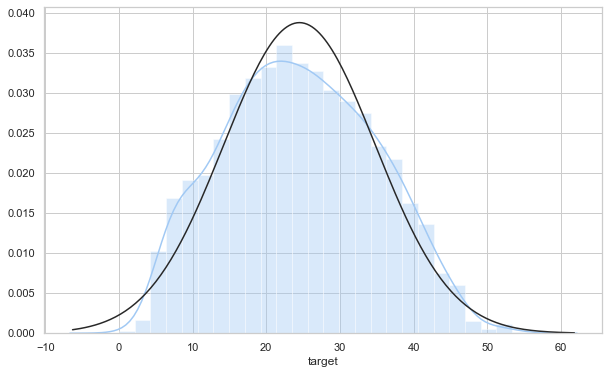

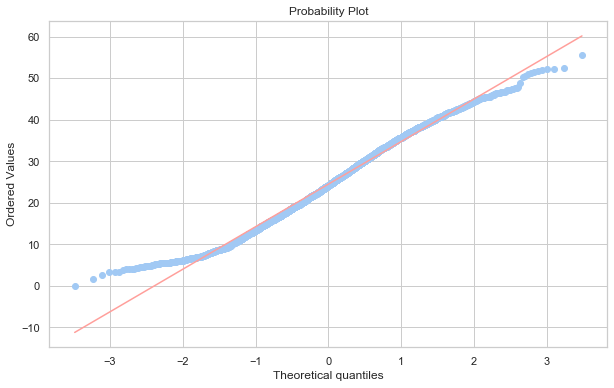

In [2133]:
#We use the numpy fuction log1p which  applies log(1+x)  para manejar ceros to all elements of the column
sns.distplot(train_trf['target'], fit=norm);

fig = plt.figure()
res = stats.probplot(train_trf['target'], plot=plt)
plt.show()

In [2134]:
train_trf.to_csv('train_trf.csv')
test_trf.to_csv('test_trf.csv')
print(train_trf.shape, test_trf.shape)

(2822, 71) (1013, 70)


### Modelling
Import librairies

In [2135]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import numpy.random as nr
import scipy.stats as ss

### Define a cross validation strategy
We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [2023]:
# train_d= np.nan_to_num(train_df)
# y_df = np.nan_to_num(y_train)

In [2024]:
# test_d = np.nan_to_num(test_df)

df = (pd.read_csv('train_df_enc.csv'))
df.head()
X= df.drop(['Unnamed: 0','target', 'ward'], axis=1)
y= df['target']
X.head()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,ADM1_PCODE,ADM1_ID,ADM1_EN,ADM2_PCODE,ADM2_ID,ADM2_EN,ADM2_TYPE,ADM3_PCODE,ADM3_ID,ADM3_EN,ADM3_TYPE,ADM4_EN,x_cordinate,y_cordinate,z_cordinate
0,1674.451,5888.208,0.934,0.001,0.005,0.001,0.000,0.001,0.006,0.031,0.008,0.003,0.001,0.008,0.260,0.608,0.000,0.010,0.122,0.283,0.717,0.274,0.726,0.119,0.881,0.833,0.012,0.002,0.051,0.000,0.001,0.076,0.006,0.004,0.000,0.000,0.005,0.003,0.007,0.357,0.563,0.004,0.073,0.002,0.919,0.743,0.214,0.020,0.003,0.008,0.000,0.013,-29.682,24.735,0.292,1,0,0,5,0,33,0,25,2,53,0,0,0.149,0.160,0.987
1,1736.992,6735.338,0.697,0.001,0.004,0.000,0.002,0.001,0.008,0.124,0.152,0.001,0.001,0.008,0.290,0.550,0.000,0.021,0.139,0.104,0.896,0.145,0.855,0.067,0.933,0.880,0.008,0.000,0.011,0.001,0.002,0.032,0.031,0.002,0.001,0.001,0.000,0.002,0.028,0.698,0.278,0.004,0.016,0.004,0.959,0.309,0.577,0.019,0.015,0.057,0.019,0.004,-29.119,24.758,3.208,1,0,0,5,0,33,0,25,2,53,0,1,0.618,0.496,0.748
2,2403.576,7273.050,0.811,0.005,0.009,0.004,0.008,0.001,0.007,0.023,0.130,0.000,0.000,0.004,0.186,0.677,0.000,0.021,0.115,0.166,0.834,0.272,0.728,0.100,0.900,0.566,0.016,0.002,0.111,0.005,0.003,0.148,0.140,0.003,0.000,0.001,0.002,0.003,0.002,0.672,0.154,0.002,0.167,0.004,0.826,0.323,0.483,0.083,0.058,0.010,0.001,0.041,-29.142,25.094,0.000,1,0,0,5,0,33,0,25,2,53,0,2,0.646,0.493,0.763
3,1740.787,5734.490,0.660,0.000,0.006,0.000,0.001,0.037,0.005,0.069,0.219,0.000,0.000,0.003,0.281,0.593,0.001,0.007,0.118,0.088,0.912,0.128,0.872,0.029,0.971,0.744,0.007,0.001,0.086,0.007,0.002,0.103,0.038,0.003,0.001,0.000,0.000,0.007,0.000,0.728,0.264,0.002,0.001,0.005,0.986,0.677,0.314,0.003,0.000,0.001,0.000,0.005,-29.372,24.943,2.039,1,0,0,5,0,33,0,25,2,53,0,3,0.447,0.406,0.890
4,1730.515,6657.238,0.951,0.001,0.001,0.001,0.007,0.001,0.005,0.009,0.015,0.009,0.000,0.001,0.197,0.518,0.001,0.005,0.280,0.346,0.654,0.405,0.595,0.134,0.866,0.423,0.014,0.001,0.122,0.007,0.003,0.147,0.082,0.003,0.000,0.001,0.001,0.004,0.192,0.753,0.130,0.005,0.107,0.005,0.957,0.771,0.195,0.010,0.005,0.001,0.001,0.018,-29.409,25.290,0.000,1,0,0,5,0,33,0,25,2,53,0,4,0.417,0.383,0.907


In [1907]:
# categorical_columns = X.columns.tolist()
# X=np.array(X)
# y=np.array(y)
# print(X.shape)
# print(y.shape)
cat_col_features=list(X.columns)

In [1910]:
# splt train test
nr.seed(9988)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2398, 80) (424, 80)
(2398,) (424,)


In [1911]:
#Validation function
# https://github.com/MizioAnd/PortfolioTimeSeriesAnalysis/blob/master/two_sigma_financial_modelling.py
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
n_folds = 5

# X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.15)
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train,y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


# def rmse_cv(model, X, y):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
#     rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring='neg_mean_squared_error', cv = kf))
#     return rmse 

### Base models

* LASSO Regression :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [1912]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.02070684579659932, random_state=1))

* Elastic Net Regression :

again made robust to outliers

In [1913]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.02070684579659932, l1_ratio=.9, random_state=3))

* Kernel Ridge Regression :

In [1914]:
KRR = KernelRidge(alpha=0.02070684579659932, kernel='polynomial', degree=2, coef0=2.5)

* Gradient Boosting Regression :

With huber loss that makes it robust to outliers

In [1915]:
GBoost = GradientBoostingRegressor(n_estimators=1200, learning_rate=0.02070684579659932,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

* XGBoost :

In [1916]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.02070684579659932, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=1200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM :

In [1917]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=3,
                              learning_rate=0.02070684579659932, n_estimators=1200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

* Catboost :

In [1921]:
#importing library and building model
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=1500,
                         learning_rate=0.02070684579659932, 
                         depth=3,
                         thread_count = 10,
                        eval_metric = "RMSE", 
                        loss_function='RMSE',
                        bagging_temperature=0.9,
                        one_hot_max_size=9,
                        random_strength=0.02070684579659932,
                        use_best_model=True,
                        max_ctr_complexity=9,
                        l2_leaf_reg=7.0950621030705965,
                        border_count=10,random_seed=1234,
                        feature_border_type='Median',
                        boosting_type='Ordered',
                          task_type = "CPU",
                        leaf_estimation_iterations = 10,
                        leaf_estimation_method='Newton',
                     verbose=100)

In [1922]:
catmodel = model.fit(x_train,y_train,eval_set=(x_train, y_train),early_stopping_rounds=250,cat_features=cat_features_size, plot=True)
catpred = catmodel.predict(x_test)

CatBoostError: Invalid cat_features[59] = 59 value: must be < 59.

### Base models scores
Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [1641]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 3.6581 (0.1420)



In [1642]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 3.6564 (0.1417)



In [1643]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 4.3365 (0.2589)



In [1644]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 3.2381 (0.1505)



In [1645]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 3.1608 (0.1393)



In [1646]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 3.4139 (0.1398)



### Stacking models

Simplest Stacking approach : Averaging base models
We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

##### Averaged base models class

In [1647]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X_train,y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X_train,y_train,)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X_test):
        predictions = np.column_stack([model.predict(X_test) for model in self.models_])
        return np.mean(predictions, axis=1)

##### Averaged base models score
We just average four models here ENet, GBoost, model_xgb, model_lgb. Of course we could easily add more models in the mix.

In [1648]:
averaged_models = AveragingModels(models = (GBoost, model_xgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 3.1730 (0.1436)



Wow ! It seems even the simplest stacking approach really improve the score . This encourages us to go further and explore a less simple stacking approch.

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

1. Split the total training set into two disjoint sets (here train and .holdout )

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

### Stacking averaged Models Class

In [1649]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=8):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [1650]:
# np.any(np.isnan(X))

In [1651]:
# np.all(np.isfinite(X))

In [1652]:
# np.isfinite(X.sum())

In [1653]:
# np.isnan(X) 

### Stacking Averaged models Score

To make the two approaches comparable (by using the same number of models) , we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [1654]:
stacked_averaged_models = StackingAveragedModels(base_models = (GBoost, model_xgb), meta_model =model_xgb)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 3.2363 (0.1697)


We get again a better score by adding a meta learner

### Ensembling StackedRegressor, XGBoost and LightGBM
We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function

In [1655]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

StackedRegressor:

In [1656]:
# averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

averaged_models = AveragingModels(models = (GBoost, model_xgb))

averaged_models.fit(X_train, y_train)
train_pred = averaged_models.predict(X_test)
ave_pred = np.expm1(averaged_models.predict(X_test))
print(rmsle(y_test, ave_pred))

6.011410755451767e+18


In [1657]:
stacked_averaged_models = StackingAveragedModels(base_models = (GBoost, model_xgb), meta_model = model_xgb)
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_test)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test))
print(rmsle(y_test, stacked_train_pred))

3.589229305612273


XGBoost:

In [1658]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_test)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_test, xgb_train_pred))

3.5760512625327796


LightGBM:

In [1659]:
GBoost.fit(X_train, y_train)
GBoost_pred =GBoost.predict(X_test)
GBoost_pred_1 = np.expm1(GBoost_pred.predict(X_test))
print(rmsle(y_test, GBoost_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [1660]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_test,stacked_train_pred/0.70 +xgb_train_pred*0.15 + GBoost_pred*0.15 ))

RMSLE score on train data:
19.782015663801662


### Ensemble prediction:

In [1661]:
test=pd.read_csv('test_df_enc.csv')
test.shape, train.shape

((1013, 82), (2822, 83))

In [1662]:
test_values = test.drop(['Unnamed: 0', 'ward'], axis=1)
test_values= test_values.fillna(test_values.mean())
test_values.shape

(1013, 80)

In [1663]:
test_values=np.array(test_values)
len(test_values)

1013

In [1665]:
ave_pred = model_xgb.predict(test_values)

In [1666]:
# ave_pred = averaged_models.predict(test_values)
# stacked_pred = stacked_averaged_models.predict(test_values)
# xgb_pred = model_xgb.predict(test_values)
# lgb_pred = model_lgb.predict(test_values)

In [1667]:
# ensemble = stacked_pred + ave_pred + lgb_pred + lgb_pred
# ensemble = stacked_pred*0.70 + ave_pred*0.70
# ensemble

In [1668]:
L_prediccion=pd.DataFrame(ave_pred,columns=['target'])
L_prediccion['ward']=test['ward']
L_prediccion['target']= L_prediccion['target']
L_prediccion.head()

,target,ward
0,21.228,21001001: Ward 1
1,14.530,21001002: Ward 2
2,20.132,21001003: Ward 3
3,18.774,21001004: Ward 4
4,23.781,21001005: Ward 5


In [1669]:
# Save and submit!
L_prediccion[['ward', 'target']].to_csv('stack_latest_submission.csv', index=False)
L_prediccion[['ward', 'target']].head()

,ward,target
0,21001001: Ward 1,21.228
1,21001002: Ward 2,14.530
2,21001003: Ward 3,20.132
3,21001004: Ward 4,18.774
4,21001005: Ward 5,23.781


In [1373]:
var_desc = pd.read_csv('stack_latest_submission.csv')
pd.set_option('display.max_colwidth', 200) # So that we can see the full descriptions
var_desc


,ward,target
0,21001001: Ward 1,20.490
1,21001002: Ward 2,13.764
2,21001003: Ward 3,20.376
3,21001004: Ward 4,18.849
4,21001005: Ward 5,23.651
...,...,...
1008,19100107: Ward 107,7.986
1009,19100108: Ward 108,24.997
1010,19100109: Ward 109,20.411
1011,19100110: Ward 110,16.174


# Quick EDA
Before we dive into modelling, let's take a quick look at the data and see what we have to work with. 
#### Plotting a specific shape

In [ ]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

In [ ]:

com_id = adm4_pcode[adm4_pcode.ADM4_PCODE == 'ZA9344001'].index.get_values()[0]
plot_shape(com_id, 'ZA9344001')

#### Plotting a complete map
Plotting a single shape was basically to work around this small part of the code:

In [ ]:
sf.shape(com_id )

In [ ]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [ ]:
# plot_map(sf)

In [ ]:
train.columns

In [ ]:
(train[['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'psa_00', 'psa_01',
       'stv_00', 'stv_01', 'car_00', 'car_01',
       'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
       'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
       'lan_12', 'pg_00', 'pg_01', 'pg_02', 'pg_03',
       'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05',
       'pw_06', 'ADM4_PCODE', 'lat', 'lon', 'NL']] == 0).sum()

In [ ]:
(test[['ward', 'total_households', 'total_individuals', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'psa_00', 'psa_01',
       'stv_00', 'stv_01', 'car_00', 'car_01',
       'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
       'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
       'lan_12', 'pg_00', 'pg_01', 'pg_02', 'pg_03',
       'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05',
       'pw_06', 'ADM4_PCODE', 'lat', 'lon', 'NL']] == 0).sum()

In [ ]:
train.describe()

In [ ]:
train_df

### Strip / trim all strings of a dataframe

In [ ]:
# train['ADM3_PCODE'] = train['ADM4_PCODE'].map(lambda x: str(x)[:-3])
# test['ADM3_PCODE'] = test['ADM4_PCODE'].map(lambda x: str(x)[:-3])

In [ ]:
train_pcode = pd.merge(train_df,adm4_pcode, how='inner', on=['ADM4_PCODE'])
test_pcode = pd.merge(test_df,adm4_pcode, how='inner', on=['ADM4_PCODE'])
train_pcode.shape,test_pcode.shape

In [ ]:
train_pcode.columns

In [ ]:
(train_pcode[['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'ADM0_PCODE', 'ADM0_EN', 'ADM1_PCODE', 'ADM1_ID', 'ADM1_EN',
       'ADM1_TYPE', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE',
       'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_REF', 'ADM3_TYPE', 'ADM4_EN',
       'ADM4_TYPE', 'SOURCE', 'coords']] == 0).sum()

In [ ]:
train_pcode = train_pcode[(train_pcode.target != 0) & train_pcode.dw_00 != 0]

In [ ]:
(train_pcode[['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'ADM0_PCODE', 'ADM0_EN', 'ADM1_PCODE', 'ADM1_ID', 'ADM1_EN',
       'ADM1_TYPE', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE',
       'ADM3_PCODE', 'ADM3_ID', 'ADM3_EN', 'ADM3_REF', 'ADM3_TYPE', 'ADM4_EN',
       'ADM4_TYPE', 'SOURCE', 'coords']] == 0).sum()

In [ ]:
train_pcode.shape

In [ ]:
train_pcode[train_pcode.ADM4_PCODE == 'ZA9344001']

In [ ]:
train_pcode.columns

In [ ]:
print('Column\tPercent Null')
for col in train_pcode:
    print(col, 100*train_pcode[col].isnull().sum()/train_pcode.shape[0])

In [ ]:
# train_pcode = train_pcode.drop(['ADM0_PCODE','ADM0_EN','ADM1_EN','ADM1_TYPE','ADM3_REF','SOURCE','ADM3_PCODE','ADM1_PCODE','ADM2_PCODE'], axis=1)
# test_pcode = test_pcode.drop(['ADM0_PCODE','ADM0_EN','ADM1_EN','ADM1_TYPE','ADM3_REF','SOURCE','ADM3_PCODE','ADM1_PCODE','ADM2_PCODE'], axis=1)

In [ ]:
train_pcode = train_pcode.drop(['ADM0_PCODE','ADM0_EN', 'ADM1_EN','ADM1_TYPE','ADM2_EN','ADM3_EN','ADM3_REF','ADM4_TYPE','SOURCE','coords','ADM4_EN'], axis=1)
test_pcode= test_pcode.drop(['ADM0_PCODE','ADM0_EN', 'ADM1_EN','ADM1_TYPE','ADM2_EN','ADM3_EN','ADM3_REF','ADM4_TYPE','SOURCE','coords','ADM4_EN'], axis=1)


In [ ]:
train_pcode.columns

In [ ]:
train_pcode.head()

In [ ]:
train_pcode = train_pcode.replace(0,float("NaN"))
test_pcode = test_pcode.replace(0,float("NaN"))

In [ ]:
train_pcode.head()

In [ ]:
train_pcode['ADM3_PCODE'].value_counts

In [ ]:
train_pcode['ADM3_PCODE'].unique()

In [ ]:
# train_pcode[['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
#        'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
#        'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
#        'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
#        'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
#        'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
#        'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
#        'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
#        'NL','ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE',
#        'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']] = train_pcode[['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
#        'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
#        'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
#        'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
#        'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
#        'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
#        'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
#        'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
#        'NL', 'ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE',
#        'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']].replace(0,float("NaN"))

In [ ]:
# test_pcode[['ward', 'total_households', 'total_individuals', 'dw_00',
#        'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
#        'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
#        'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
#        'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
#        'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
#        'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
#        'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
#        'NL','ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE',
#        'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']] = test_pcode[[
#        'ward', 'total_households', 'total_individuals', 'dw_00',
#        'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
#        'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
#        'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
#        'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
#        'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
#        'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
#        'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
#        'NL','ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE',
#        'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']].replace(0,float("NaN"))

In [ ]:
train_pcode.head()

In [ ]:
test_pcode.head()

In [ ]:
# how far is each row from wurster hall?
def get_distance(row):
    ward_1 = 24.734743, -29.682270
    distance = great_circle(ward_1, (row['lat'], row['lon'])).miles
    return round(distance, 4)

# train_pcode['miles_from_ward'] = train_pcode.apply(get_distance, axis=1)
# test_pcode['miles_from_ward'] = test_pcode.apply(get_distance, axis=1)
# train_pcode.head()

In [ ]:
# create a geometry column in our point dataset to contain shapely geometry for geopandas to use
# notice the points are represented as long, lat so that they are equivalent to x, y
# train_pcode['geometry'] = train_pcode.apply(lambda row: Point(row['lat'], row['lon']), axis=1)
# test_pcode['geometry'] = test_pcode.apply(lambda row: Point(row['lat'], row['lon']), axis=1)
# train_pcode.head()

In [ ]:
# convert the projected points into discrete x and y columns for easy matplotlib scatter-plotting
# test_pcode['ward_x'] = test_pcode['geometry'].map(lambda point: point.x)
# test_pcode['ward_y'] = test_pcode['geometry'].map(lambda point: point.y)
# test_pcode.head()

In [ ]:
train_pcode.isnull().sum()

In [ ]:
test_pcode.isnull().sum()

## Household_Size
The population and the housing types that will meet their needs can be viewed by the way individuals live together. Average household size (people per household) is calculated by dividing the household population by total households. Households include all persons living together, regardless of their relationship[i]. Average household size can also be a reflection of personal or cultural preferences or economic choices. A mismatch between household size and the size (square footage and number of bedrooms) of the dwelling can indicate a lack of adequate housing or unmet housing need for either larger or smaller homes. Anticipating changes in the size and composition of households is important for many housing-related issues and associated policies, including the needs of elderly single-person households, intergenerational housing options, and housing types to meet all life cycles [ii]. Broadly, the changing composition of households may create a demand for the design and price of new housing types [iii].

In [ ]:
# # train_pcode['total_individuals'].min()
# train_pcode = train_pcode[train_pcode['total_households']> 1]
# train_pcode.shape

In [ ]:
# train_pcode['total_individuals']= np.log(train_pcode['total_individuals'])
# train_pcode['total_households']= np.log(train_pcode['total_households'])

# test_pcode['total_individuals']= np.log(test_pcode['total_individuals'])
# test_pcode['total_households']= np.log(test_pcode['total_households'])

In [ ]:
# Average household size - might contain some useful information
train_pcode['average_household_Size'] = train_pcode['total_individuals']/train_pcode['total_households']
test_pcode['average_household_Size'] = test_pcode['total_individuals']/test_pcode['total_households']

In [ ]:
# # items_popularity['popularity_scale_10'] = np.array(np.round((items_popularity['pop_percent'] * 10)), dtype='int')
# train_pcode['average_household_popularity_scale_100'] = np.array(np.round((train_pcode['average_household_Size'] * 100)), dtype='int')
# test_pcode['average_household_popularity_scale_100'] = np.array(np.round((test_pcode['average_household_Size'] * 100)), dtype='int')

In [ ]:
# train_pcode['average_household_Size_log']= np.log(1+train_pcode['average_household_Size'])
# test_pcode['average_household_Size_log']= np.log(1+test_pcode['average_household_Size'])


# train_pcode['total_individuals_log'] = np.log((1+ train_pcode['total_individuals']))
# train_pcode['total_households_log'] = np.log((1+ train_pcode['total_households']))

# test_pcode['total_individuals_log'] = np.log((1+ test_pcode['total_individuals']))
# test_pcode['total_households_log'] = np.log((1+ test_pcode['total_households']))

# train_pcode['average_individual']=np.array(np.round(((train_pcode['total_individuals']/train_pcode['total_individuals'].count()) * 100)), dtype='int')
# test_pcode['average_individual']=np.array(np.round(((test_pcode['total_individuals']/test_pcode['total_individuals'].count()) * 100)), dtype='int')

# train_pcode['average_households']=np.array(np.round(((train_pcode['total_households']/train_pcode['total_households'].count()) * 100)), dtype='int')
# test_pcode['average_households']=np.array(np.round(((test_pcode['total_households']/test_pcode['total_households'].count()) * 100)), dtype='int')

In [ ]:
#percentage of households per ward
def percentage_household_size(x):
    return x / 100

In [ ]:
# # # Percentage of Average household size - might contain some useful information
# train_pcode['percentage_Household_Size'] = train_pcode['Household_Size'].apply(lambda percent: percentage_household_size(percent))
# test_pcode['percentage_household_size'] = test_pcode['Household_Size'].apply(lambda percent: percentage_household_size(percent))

# train['percentage_household_size'] = train.apply(transform(train['Household_Size'] ,axis=1))
# test['percentage_household_size'] = test.apply(transform(test['Household_Size'],axis=1))

In [ ]:
train_pcode.head()

## Basic approach LE.
LE (label encoding) is the most simple. We have some categories (country for example) ['Russia', 'USA', 'GB']. But algoritms do not work with strings, they need numbers. Ok, we can do it ['Russia', 'USA', 'GB'] -> [0, 1, 2]. Really simple. Let's try.

In [ ]:
train.columns

In [ ]:
# ward_to_int = dict((zip(train_pcode.ward.unique(), range(train_pcode.ward.unique().shape[0]))))
# adm4_to_int = dict((zip(train_pcode.ADM4_PCODE.unique(), range(train_pcode.ADM4_PCODE.unique().shape[0]))))

# tst_ward_to_int = dict((zip(test_pcode.ward.unique(), range(test_pcode.ward.unique().shape[0]))))
# tst_adm4_to_int = dict((zip(test_pcode.ADM4_PCODE.unique(), range(test_pcode.ADM4_PCODE.unique().shape[0]))))

train_df_le = train_pcode.copy(deep=True)
test_df_le = test_pcode.copy(deep=True)

In [ ]:
# train_df_le = pd.get_dummies(train_df_le, prefix=['ADM1_ID', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE', 'ADM3_ID',
#        'ADM3_EN', 'ADM3_TYPE',], columns=['ADM1_ID', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE', 'ADM3_ID',
#        'ADM3_EN', 'ADM3_TYPE',])

# test_df_le = pd.get_dummies(test_df_le, prefix=['ADM1_ID', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE', 'ADM3_ID',
#        'ADM3_EN', 'ADM3_TYPE',], columns=['ADM1_ID', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE', 'ADM3_ID',
#        'ADM3_EN', 'ADM3_TYPE',])

In [ ]:
# ['ADM1_ID', 'ADM2_ID', 'ADM2_EN', 'ADM2_TYPE', 'ADM3_ID', 'ADM3_EN', 'ADM3_TYPE']
train_df_le['ADM1_PCODE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM1_PCODE'])
train_df_le['ADM1_ID'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM1_ID'])
train_df_le['ADM2_PCODE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM2_PCODE'])
train_df_le['ADM2_ID'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM2_ID'])
train_df_le['ADM2_TYPE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM2_TYPE'])
train_df_le['ADM3_PCODE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM3_PCODE'])
train_df_le['ADM3_ID'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM3_ID'])
train_df_le['ADM3_TYPE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM3_TYPE'])
# train_df_le['ward'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ward'])
# train_df_le['ADM4_PCODE'] = preprocessing.LabelEncoder().fit_transform(train_df_le['ADM4_PCODE'])

# from sklearn.preprocessing import LabelEncoder

# lb_make = LabelEncoder()
# train_df_le['ward']  = lb_make.fit_transform(train_df_le['ward'] )

In [ ]:
test_df_le['ADM1_PCODE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM1_PCODE'])
test_df_le['ADM1_ID'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM1_ID'])
test_df_le['ADM2_PCODE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM2_PCODE'])
test_df_le['ADM2_ID'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM2_ID'])
test_df_le['ADM2_TYPE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM2_TYPE'])
test_df_le['ADM3_PCODE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM3_PCODE'])
test_df_le['ADM3_ID'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM3_ID'])
test_df_le['ADM3_TYPE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM3_TYPE'])
# test_df_le['ward'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ward'])
# test_df_le['ADM4_PCODE'] = preprocessing.LabelEncoder().fit_transform(test_df_le['ADM4_PCODE'])




# from sklearn.preprocessing import LabelEncoder

# lb_make = LabelEncoder()
# test_df_le['ward'] = lb_make.fit_transform(test_df_le['ward'])
# # obj_df[["make", "make_code"]].head(11)

In [ ]:
train_df_le.head()

In [ ]:
test_df_le.head()

In [ ]:
# train_df_le = train_df_le.drop(['ADM2_ID','ADM1_ID', 'ADM3_ID', 'ADM2_TYPE', 'ADM3_TYPE'], axis=1)
# test_df_le = test_df_le.drop(['ADM2_ID','ADM1_ID', 'ADM3_ID', 'ADM2_TYPE', 'ADM3_TYPE'], axis=1)

train_df_le = train_df_le.drop(['ward','ADM4_PCODE'], axis=1)
test_df_le = test_df_le.drop(['ward','ADM4_PCODE'], axis=1)

In [ ]:
# train_df_le['ward'] = train_df_le['ward'].apply(lambda ward: ward_to_int[ward])
# train_df_le['ADM4_PCODE'] = train_df_le['ADM4_PCODE'].apply(lambda adm4: adm4_to_int[adm4])
# test_df_le['ward'] = test_df_le['ward'].apply(lambda tst_ward: tst_ward_to_int[tst_ward])
# test_df_le['ADM4_PCODE'] = test_df_le['ADM4_PCODE'].apply(lambda tst_adm4: tst_adm4_to_int[tst_adm4])

In [ ]:
train_df_le = train_df_le.fillna(train_df_le.median())
test_df_le = test_df_le.fillna(test_df_le.median())

In [ ]:
train_df_le.isnull().sum()

In [ ]:
# train_df_le['ward']  = train_df_le['ward'].astype(np.int64)
# train_df_le['ADM4_PCODE'] = train_df_le['ADM4_PCODE'].astype(np.int64)

In [ ]:
# test_df_le['ward'] = test_df_le['ward'].astype(np.int64)
# test_df_le['ADM4_PCODE'] = test_df_le['ADM4_PCODE'].astype(np.int64)

In [ ]:
# train_df_le.ward = train_df_le.ward.map(lambda x: int(x) if str(x) != '\\N' else '')

In [ ]:
# test_df_le.ward = test_df_le.ward.map(lambda x: int(x) if str(x) != '\\N' else '')

In [ ]:
# train_df_le['ward'] = train_df_le['ward'].fillna(train_df_le['ward'].median())
# test_df_le['ward']= test_df_le['ward'].fillna(test_df_le['ward'].median())

In [ ]:
# num_cols = ['ward']
# train_df_le[num_cols] = train_df_le[num_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# test_df_le[num_cols] = test_df_le[num_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# train_df_le['ward'] = pd.to_numeric(train_df_le ['ward'], errors='coerce').fillna(0).astype(int)
# train_df_le.dtypes.tolist()

In [ ]:
test_df_le.dtypes.tolist()

In [ ]:
train_df_le.head()

In [ ]:
# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

# train_df_le = clean_dataset(train_df_le)
# test_df_le = clean_dataset(test_df_le)

In [ ]:
test_df_le.head()

# Modelling
At this stage, most tutorials/notebooks would go into feature engineering. But I like to do a quick model FIRST, to see how tough the problem is and give us a baseline to compare to. So, in this section we'll try a simple linear model and then a more complicated Random Forest regressor, and set up a means to score our models locally (so that we don't have to keep submitting on Zindi).

## Standardization

Features will be rescaled so that they’ll have the properties of a standard normal distribution with mean m = 0, and standart deviation d = 0.

In [ ]:
train_df_le.dtypes

In [ ]:
# cat = ['ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']
# train_df_le[cat]= train_df_le[cat].astype('object')
# test_df_le[cat]= test_df_le[cat].astype('object')

In [ ]:
# convert categorical columns to integers
category_cols =['ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']
cat_dims = [train_df_le.columns.get_loc(i) for i in category_cols[:]] 
for header in category_cols:
    train_df_le[header] = train_df_le[header].astype('object')
    test_df_le[header] = test_df_le[header].astype('object')
print(cat_dims)

In [ ]:
category_cols[:]

In [ ]:
train_df_le.dtypes

In [ ]:
train_df_le.columns
categorical_features_indices = np.where(train_df_le.dtypes != np.float)[0]
categorical_features_indices

In [ ]:
# train_df_le['ward'].unique().tolist()

In [ ]:
trainCol = train_df_le.columns

obj_column = []

for column in trainCol:
    if(train_df_le[column].dtypes == 'object'):
        obj_column.append(column)
        
print(obj_column)

#### LR label encoded

Linear models like scaled input

In [ ]:
# Define our input columns.
# Specify our target variable
# cat = ['ADM1_PCODE', 'ADM1_ID', 'ADM2_PCODE', 'ADM2_ID', 'ADM2_TYPE', 'ADM3_PCODE', 'ADM3_ID', 'ADM3_TYPE']
# train_df_le[cat]= train_df_le[cat].astype('object')
# test_df_le[cat]= test_df_le[cat].astype('object')

# def column_index(df, query_cols):
#     cols = df.columns.values
#     sidx = np.argsort(cols)
#     return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

# # cate = X.columns.tolist() #categorical[:-1]
# for col in cat:
#     X[col] = X[col].astype(np.int64)
# categorical_features_pos = column_index(X,cat)

# # test[cat]=test[cat].astype(object)
# # X[cat]=X[cat].astype(object)


# train_df_le = train_df_le.drop(['psa_03','psa_04','lan_14'], axis=1)
# test_df_le = test_df_le.drop(['psa_03','psa_04','lan_14'], axis=1)
y = train_df_le.target
X = train_df_le.drop('target', axis=1)
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.15)

In [ ]:
y.shape,X.shape

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# random_state  = 42
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.15)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
# # Fit a basic linear regression model, keeping the last 1000 rows for scoring
# from sklearn.linear_model import LinearRegression
# lm = LinearRegression()
# lm.fit(X_train, y_train)
# lm_preds = lm.predict(X_test)
# mean_absolute_error(y_test, lm_preds)

### Evaluating Predictions

How do we evaluate our predictions? if we run `lm.score(df[in_cols][-1000:], df[ycol][-1000:])`, we'll get something called the 'R-Squared Score', which is a measure of how well our model explains the variation in the target variable. The closer to 1, the better. But this can be hard to visualize, so I like to plot predictions vs true values to get a better idea of how close our model is coming.

Neither of these tell us what our score on Zindi will look like. The metric used to evaluate submissions is RMSE - more info [here](https://www.statisticshowto.datasciencecentral.com/rmse/). 

Let's evaluate our first linear model:

In [ ]:
# lm.score(X_test, y_test) # R2 score

In [ ]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# print("RMSE:", sqrt(mean_squared_error(y_test, lm_preds)))

In [ ]:
# # Plot predicted vs actual
# plt.scatter(y_test, lm_preds, alpha=0.3)
# plt.plot(y_test, y_test) # A straight line - we want to be close to this
# plt.xlabel('True Value')
# plt.ylabel('Predicted Value')
# plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

So the model is getting most predictions close to the mark, but some are waaaay off (causing the terrible score) and lots are negative! Let's move on to a better model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# rf = RandomForestRegressor(n_estimators=100) # My go-to quick model for regression tasks.
# rf.fit(X_train, y_train)
# rf_preds = rf.predict(X_test)
# print ("Random Forest Score: ",mean_absolute_error(y_test, rf_preds))
# print ("Random Forest Score: ",rf.score(X_test, y_test))# Very good!
# print("RMSE: ", sqrt(mean_squared_error(y_test, rf_preds)))

In [ ]:
# plt.scatter(y_test, rf_preds, alpha=0.3)
# plt.plot(y_test, y_test) # A straight line - we want to be close to this
# plt.xlabel('True Value')
# plt.ylabel('Predicted Value')
# plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

Much better! We can see that the predicted values now line up fairly closely with the true values. 

A nice side-effect of this Random Forest model: We can see what features are most important to the model:

In [ ]:
# @jit
# def eval_gini(y_true, y_prob):
#     y_true = np.asarray(y_true)
#     y_true = y_true[np.argsort(y_prob)]
#     ntrue = 0
#     gini = 0
#     delta = 0
#     n = len(y_true)
#     for i in range(n-1, -1, -1):
#         y_i = y_true[i]
#         ntrue += y_i
#         gini += y_i * delta
#         delta += 1 - y_i
#     gini = 1 - 2 * gini / (ntrue * (n - ntrue))
#     return gini


# MAX_ROUNDS = 1100
# OPTIMIZE_ROUNDS = False
# LEARNING_RATE = 0.02070684579659932
# from numba import jit
# y_valid_pred = 0*y
# y_test_pred = 0

# # Set up folds
# K = 3
# import numpy.random as nr
# rng = np.random.RandomState (31337)
# from sklearn.model_selection import KFold

# # Demonstrating splits
# kf = KFold(n_splits = K, random_state = 42, shuffle = True)

# # Run CV
# scores = []
# # for md in [3, 4, 5, 7, 9, 12, 15]:
# for i, (train_index, test_index) in enumerate(kf.split(train_df_le)):
#     model = CatBoostRegressor(
#                         iterations=MAX_ROUNDS,random_state=1,
#                         learning_rate=LEARNING_RATE, 
#                         depth=3,
#                         thread_count = 10,
#                         task_type = "CPU",
#                         eval_metric = "RMSE",
#                         loss_function= 'RMSE', 
#                         bagging_temperature=0.9,
#                         one_hot_max_size=75,
#                         use_best_model=True,
#                         max_ctr_complexity=10,
#                         l2_leaf_reg=7.0950621030705965,
#                         cat_features=obj_column,
#                         verbose=100)

#     # Create data for this fold
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
#     X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
#     print( "\nFold ", i)
#     # Run model for this fold
#     if OPTIMIZE_ROUNDS:
#         fit_model = model.fit( X_train, y_train, eval_set=[X_valid, y_valid])
#         print( "  N trees = ", model.tree_count_ )
#     else:
#         fit_model = model.fit(X_train, y_train,eval_set=[(X_valid, y_valid)])

#     # Generate validation predictions for this fold
#     pred  = fit_model.predict(X_valid)
#     print( "  Gini = ", eval_gini(y_valid, pred) )
#     y_valid_pred.iloc[test_index] = pred

#     # Accumulate test set predictions
#     y_test_pred += fit_model.predict(test_df_le)[:]

# #         rmse = sqrt(mean_squared_error(y.iloc[test_index], y_test_pred ))
# #         scores.append(rmse)
# #         print(rmse)
        
# y_test_pred /= K  # Average test set predictions

# print( "\nGini for full training set:" )
# eval_gini(y, y_valid_pred)
# print(y.iloc[train_index].shape, y.iloc[test_index].shape)
# print(X.iloc[train_index,:].shape,X.iloc[test_index,:].shape)
    

In [ ]:
# from sortedcontainers import SortedList
# import copy
# import collections
# import numpy as np
# from itertools import product,chain
# import pandas
# from sklearn.model_selection import KFold
# import catboost as cb


# class paramsearch:
#     def __init__(self,pdict):    
#         self.pdict = {}
#         # if something is not passed in as a sequence, make it a sequence with 1 element
#         #   don't treat strings as sequences
#         for a,b in pdict.items():
#             if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
#             else: self.pdict[a] = [b]
#         # our results are a sorted list, so the best score is always the final element
#         self.results = SortedList()       
                    
#     def grid_search(self,keys=None):
#         # do grid search on only the keys listed. If none provided, do all
#         if keys==None: keylist = self.pdict.keys()
#         else: keylist = keys
 
#         listoflists = [] # this will be list of lists of key,value pairs
#         for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
#         for p in product(*listoflists):
#             # do any changes to the current best parameter set
#             if len(self.results)>0: template = self.results[-1][1]
#             else: template = {a:b[0] for a,b in self.pdict.items()}
#             # if our updates are the same as current best, don't bother
#             if self.equaldict(dict(p),template): continue
#             # take the current best and update just the ones to change
#             yield self.overwritedict(dict(p),template)
                              
#     def equaldict(self,a,b):
#         for key in a.keys(): 
#             if a[key] != b[key]: return False
#         return True            
                              
#     def overwritedict(self,new,old):
#         old = copy.deepcopy(old)
#         for key in new.keys(): old[key] = new[key]
#         return old            
    
#     # save a (score,params) pair to results. Since 'results' is a sorted list,
#     #   the best score is always the final element. A small amount of noise is added
#     #   because sorted lists don't like it when two scores are exactly the same    
#     def register_result(self,result,params):
#         self.results.add((result+np.random.randn()*1e-10,params))    
        
#     def bestscore(self):
#         return self.results[-1][0]
        
#     def bestparam(self):
#         return self.results[-1][1]

In [ ]:
# from sklearn.model_selection import KFold
# from itertools import product,chain

# params = {'depth':[3,2,6,4,5],
#           'iterations':[1000,1500,2000,2500],
#           'learning_rate':[0.0307,0.0207,0.0407,0.0107], 
#           'l2_leaf_reg':[5,6,7,8,10],
#           'border_count':[8,9,10,20],
#           'thread_count':[2,4,6,10],
#           'bagging_temperature':[0.8,0.9,1],
#           'one_hot_max_size': [8,9,10,11],
#           'max_ctr_complexity': [5,10,15]
#          }

# # this function does 3-fold crossvalidation with catboostclassifier          
# # def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
# cat_dims=obj_column
# def crossvaltest(params,X,y,cat_dims,n_splits=3):

#     kf = KFold(n_splits=n_splits,shuffle=True) 
#     res = []
#     for train_index, test_index in kf.split(X):
        
#         y_train = y.iloc[train_index]
#         y_valid = y.iloc[test_index]
        
#         X_train = X.iloc[train_index,:]
#         X_valid = X.iloc[test_index,:]
        
        
        
# #         train = train_set.iloc[train_index,:]
# #         test = train_set.iloc[test_index,:]
        
# #         labels = train_label.ix[train_index]
# #         test_labels = train_label.ix[test_index]
        
        
#         clf = cb.CatBoostRegressor(**params,eval_metric= "RMSE",loss_function= 'RMSE')
# #         clf.fit(X_train, y_train,eval_set=[(X_valid, y_valid)])
                        
            
        
#         clf.fit(X_train, np.ravel(y_train), cat_features=cat_dims,eval_set=[(X_valid, y_valid)])

#          # Accumulate test set predictions
#         y_test_pred = clf.predict(X_valid)
#         res.append(np.mean(y_test_pred==np.ravel(y_valid))) # Average test set predictions
# #     y_test_pred /= K  
#     return np.mean(res)


# # this function runs grid search on several parameters
# def catboost_param_tune(params,X,y,cat_dims=None,n_splits=3):
#     ps = paramsearch(params)
#     # search 'border_count', 'l2_leaf_reg' etc. individually 
#     #   but 'iterations','learning_rate' together
#     for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['l2_leaf_reg']),
#                       ps.grid_search(['iterations','learning_rate']),
#                       ps.grid_search(['depth']),
#                       ps.grid_search(['bagging_temperature']),
#                       ps.grid_search(['one_hot_max_size']),
#                       ps.grid_search(['max_ctr_complexity'])):
#         res = crossvaltest(prms,X,y,cat_dims,n_splits)
#         # save the crossvalidation result so that future iterations can reuse the best parameters
#         ps.register_result(res,prms)
#         print(res,prms,'best:',ps.bestscore(),ps.bestparam())
#     return ps.bestparam()

# bestparams = catboost_param_tune(params,X,y,cat_dims)

In [ ]:
bestparams

In [ ]:
# # train classifier with tuned parameters    
# clf = cb.CatBoostRegressor(**bestparams)
# clf.fit(X_train,np.ravel(y_train),eval_set=(X_test,y_test), cat_features=obj_column)


In [ ]:
# res = clf.predict(test_df_le)
# print('error:',1-np.mean(res==np.ravel(test_df_le['target'])))

In [1923]:
#importing library and building model
from catboost import CatBoostRegressor


model = CatBoostRegressor(iterations=1500,random_state=1,
                         learning_rate=0.02070684579659932, 
                         depth=3,
                         thread_count = 10,
                        eval_metric = "RMSE",
                        loss_function= 'RMSE', 
                        bagging_temperature=0.9,
                        one_hot_max_size=9,
                        use_best_model=True,
                        max_ctr_complexity=10,
                        l2_leaf_reg=7.0950621030705965,
                        border_count=10,
                     verbose=100)


# model = CatBoostRegressor(
#     iterations=1200,
#     depth=3,
#     learning_rate=0.02070684579659932,
#     l2_leaf_reg= 9,#def=3
#     loss_function='RMSE',
#     eval_metric='RMSE',
#     random_strength=0.0207,
#     bootstrap_type='Bayesian',#Poisson (supported for GPU only);Bayesian;Bernoulli;No
#     bagging_temperature=0.9,#for Bayesian bootstrap_type; 1=exp;0=1
#     leaf_estimation_method='Newton', #Gradient;Newton
#     leaf_estimation_iterations=2,
#     boosting_type='Ordered' #Ordered-small data sets; Plain
#     ,task_type = "CPU"
#     ,feature_border_type='Median' #Median;Uniform;UniformAndQuantiles;MaxLogSum;MinEntropy;GreedyLogSum
#     ,random_seed=1234, verbose=100
# )




catmodel = model.fit(X_train,y_train,eval_set=(X_test,y_test), cat_features=obj_column, plot=True)
catpred = catmodel.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 26.0555594	test: 26.2078061	best: 26.2078061 (0)	total: 91.3ms	remaining: 2m 16s
100:	learn: 5.7414833	test: 6.0613509	best: 6.0613509 (100)	total: 4.68s	remaining: 1m 4s
200:	learn: 4.0291876	test: 4.3773643	best: 4.3773643 (200)	total: 9.4s	remaining: 1m
300:	learn: 3.7449785	test: 4.0635813	best: 4.0635813 (300)	total: 14s	remaining: 55.8s
400:	learn: 3.5745927	test: 3.8948331	best: 3.8948331 (400)	total: 18.8s	remaining: 51.5s
500:	learn: 3.4540118	test: 3.8040452	best: 3.8040452 (500)	total: 23.2s	remaining: 46.3s
600:	learn: 3.3624783	test: 3.7468747	best: 3.7466823 (599)	total: 28.1s	remaining: 42.1s
700:	learn: 3.2872065	test: 3.6997959	best: 3.6997959 (700)	total: 32.9s	remaining: 37.5s
800:	learn: 3.2127746	test: 3.6602287	best: 3.6602287 (800)	total: 37.5s	remaining: 32.7s
900:	learn: 3.1497216	test: 3.6289043	best: 3.6289043 (900)	total: 42.3s	remaining: 28.1s
1000:	learn: 3.1097359	test: 3.6148101	best: 3.6145349 (992)	total: 46.7s	remaining: 23.3s
1100:	learn: 3

In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import StratifiedKFold
# # from sklearn.grid_search import ParameterGrid
# from sklearn.model_selection import train_test_split
# from itertools import product, chain
# from tqdm import tqdm
# from sklearn.model_selection import learning_curve, GridSearchCV,ParameterGrid

# # https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# RANDOM_STATE = 0
# def cross_val(X, y, X_test, param, cat_features, n_splits=3):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
#     acc = []
#     predict = None
    
#     for tr_ind, val_ind in skf.split(X, y):
#         X_train = X[tr_ind]
#         y_train = y[tr_ind]
        
#         X_valid = X[val_ind]
#         y_valid = y[val_ind]
        
#         clf = CatBoostRegressor(iterations=1500,
#                                  learning_rate=0.02070684579659932,
#                                 loss_function = param['loss_function'],
#                                 depth=param['depth'],
#                                 l2_leaf_reg = param['l2_leaf_reg'],
#                                 eval_metric = 'RMSE',
#                                 leaf_estimation_iterations = 10,
#                                 leaf_estimation_method='Newton',
#                                 use_best_model=True,
#                                 logging_level='Silent',
#                                 bagging_temperature=0.9,
#                                 random_seed=1234, verbose=100,
#                                 task_type = "CPU",
#                                 boosting_type='Ordered',
#                                 feature_border_type='Median'
#         )
        
#         clf.fit(X_train, 
#                 y_train,
#                 cat_features=obj_column,
#                 eval_set=(X_valid, y_valid)
#         )
        
#         y_pred = clf.predict(X_valid)
#         accuracy = accuracy_score(y_valid, y_pred)
#         acc.append(accuracy)
#     return sum(acc)/n_splits

In [ ]:
# def catboost_GridSearchCV(X, y, X_test, params, cat_features, n_splits=5):
#     ps = {'acc':0,
#           'param': []
#     }
    
#     predict=None
    
#     for prms in tqdm(list(ParameterGrid(params)), ascii=True, desc='Params Tuning:'):
                          
#         acc = cross_val(X, y, X_test, prms, cat_features, n_splits=5)

#         if acc>ps['acc']:
#             ps['acc'] = acc
#             ps['param'] = prms
#     print('Acc: '+str(ps['acc']))
#     print('Params: '+str(ps['param']))
    
#     return ps['param']
    
    


In [ ]:

# #     train = pd.read_csv("../input/train.csv")
# #     test = pd.read_csv("../input/test.csv")
    
# #     X_train, y_train = get_xy(train)
# #     X_test, cat_features = get_x(test)
    
# params_sea = {'depth':[2, 3, 4],
#           'loss_function': ['Logloss', 'RMSE'],
#           'l2_leaf_reg':np.logspace(-20, -19, 7)
# }

# param = catboost_GridSearchCV(X_train, y_train, X_test, params=params_sea, cat_features=categorical_features_indices)

# clf = CatBoostRegressor(iterations=1500,
#                              learning_rate=0.02070684579659932,
#                             loss_function = param['loss_function'],
#                             depth=param['depth'],
#                             l2_leaf_reg = param['l2_leaf_reg'],
#                             eval_metric = 'RMSE',
#                             leaf_estimation_iterations = 10,
#                             leaf_estimation_method='Newton',
#                             use_best_model=True,
#                             logging_level='Silent',
#                             bagging_temperature=0.9,
#                             random_seed=1234, verbose=100,
#                             task_type = "CPU",
#                             boosting_type='Ordered',
#                             feature_border_type='Median'
#     )

# X_train, X_valid, y_train, y_valid = train_test_split(X_train,
#                                                     y_train, 
#                                                     shuffle=True,
#                                                     random_state=RANDOM_STATE,
#                                                     train_size=0.8,
#                                                     stratify=y_train
# )
# clf.fit(X_train, 
#         y_train,
#         cat_features=categorical_features_indices,
#         logging_level='Silent',
#         eval_set=(X_valid, y_valid)
# )
# sub = pd.DataFrame({'ward':test['ward'],'target':np.array(clf.predict(test_df_le)).astype(int)})
# sub.to_csv('cat_sub_1.csv',index=False)


In [ ]:
test_df_le.head()

In [ ]:
train_df_le.head()

# Making a submission

OK, so we have a model we're happy with. Now to make our submission. First, let's look at the submission format

In [ ]:
submission_df = pd.read_csv('SampleSubmission.csv')
submission_df.head()

In [ ]:
submission_df.target.dtypes

In [ ]:
test_df_le['target'] = model.predict(test_df_le)
test['target'] = test_df_le['target']
test_df_le.head()

In [ ]:
# # Make predictions
# test['target'] = test_df_le['target']
# # test['ward']= test['ward'].astype('object')
# test['target'] = y_test_pred
# test.head()

In [ ]:
# Save and submit!
test[['ward', 'target']].to_csv('submission_new.csv', index=False)


And that's it! Upload your submission file to Zindi and see what you get :) If all works out well, you should get a score very similar to the one we got in our tests. That said, the test set includes Cape Town, so if your score is slightly lower than expected feel free to blame it on the DA ;)